In [360]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar import vecm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
from xgboost import XGBRegressor
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm.autonotebook import tqdm
from gluonts.evaluation import Evaluator

In [270]:
df = pd.read_csv('220511_monatszahlenmonatszahlen2204_verkehrsunfaelle.csv')
df

MONATSZAHL             AUSPRAEGUNG  JAHR   MONAT   WERT  \
0      Alkoholunfälle               insgesamt  2022  202201    NaN   
1      Alkoholunfälle               insgesamt  2022  202202    NaN   
2      Alkoholunfälle               insgesamt  2022  202203    NaN   
3      Alkoholunfälle               insgesamt  2022  202204    NaN   
4      Alkoholunfälle               insgesamt  2022  202205    NaN   
...               ...                     ...   ...     ...    ...   
2081  Verkehrsunfälle  Verletzte und Getötete  2000  200008  647.0   
2082  Verkehrsunfälle  Verletzte und Getötete  2000  200009  675.0   
2083  Verkehrsunfälle  Verletzte und Getötete  2000  200010  615.0   
2084  Verkehrsunfälle  Verletzte und Getötete  2000  200011  578.0   
2085  Verkehrsunfälle  Verletzte und Getötete  2000  200012  515.0   

      VORJAHRESWERT  VERAEND_VORMONAT_PROZENT  VERAEND_VORJAHRESMONAT_PROZENT  \
0              16.0                       NaN                             NaN   
1              14.0                       NaN                             NaN   
2              24.0                       NaN                             NaN   
3              16.0                       NaN                             NaN   
4              24.0                       NaN                             NaN   
...             ...                       ...                             ...   
2081            NaN                    -13.04                             NaN   
2082            NaN                      4.33                             NaN   
2083            NaN                     -8.89                             NaN   
2084            NaN                     -6.02                             NaN   
2085            NaN                    -10.90                             NaN   

      ZWOELF_MONATE_MITTELWERT  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  
...                        ...  
2081                     584.0  
2082                     594.0  
2083                     596.0  
2084                     594.0  
2085                     588.0  

[2086 rows x 9 columns]

In [15]:
# Get first 5 columns
df = df.iloc[:,:5]
df

MONATSZAHL             AUSPRAEGUNG  JAHR   MONAT   WERT
0      Alkoholunfälle               insgesamt  2022  202201    NaN
1      Alkoholunfälle               insgesamt  2022  202202    NaN
2      Alkoholunfälle               insgesamt  2022  202203    NaN
3      Alkoholunfälle               insgesamt  2022  202204    NaN
4      Alkoholunfälle               insgesamt  2022  202205    NaN
...               ...                     ...   ...     ...    ...
2081  Verkehrsunfälle  Verletzte und Getötete  2000  200008  647.0
2082  Verkehrsunfälle  Verletzte und Getötete  2000  200009  675.0
2083  Verkehrsunfälle  Verletzte und Getötete  2000  200010  615.0
2084  Verkehrsunfälle  Verletzte und Getötete  2000  200011  578.0
2085  Verkehrsunfälle  Verletzte und Getötete  2000  200012  515.0

[2086 rows x 5 columns]

In [16]:
df.dtypes

MONATSZAHL      object
AUSPRAEGUNG     object
JAHR             int64
MONAT           object
WERT           float64
dtype: object

In [17]:
# Filter data till 2020. Store 2021 onwards data in test df 
test_df = df[df['JAHR'] > 2020]
display(test_df)
df = df[df['JAHR'] <= 2020]
df

MONATSZAHL             AUSPRAEGUNG  JAHR   MONAT   WERT
0      Alkoholunfälle               insgesamt  2022  202201    NaN
1      Alkoholunfälle               insgesamt  2022  202202    NaN
2      Alkoholunfälle               insgesamt  2022  202203    NaN
3      Alkoholunfälle               insgesamt  2022  202204    NaN
4      Alkoholunfälle               insgesamt  2022  202205    NaN
...               ...                     ...   ...     ...    ...
1808  Verkehrsunfälle  Verletzte und Getötete  2021  202108  531.0
1809  Verkehrsunfälle  Verletzte und Getötete  2021  202109  678.0
1810  Verkehrsunfälle  Verletzte und Getötete  2021  202110  561.0
1811  Verkehrsunfälle  Verletzte und Getötete  2021  202111  430.0
1812  Verkehrsunfälle  Verletzte und Getötete  2021  202112  340.0

[175 rows x 5 columns]

MONATSZAHL             AUSPRAEGUNG  JAHR   MONAT   WERT
25     Alkoholunfälle               insgesamt  2020   Summe  430.0
26     Alkoholunfälle               insgesamt  2020  202001   28.0
27     Alkoholunfälle               insgesamt  2020  202002   40.0
28     Alkoholunfälle               insgesamt  2020  202003   27.0
29     Alkoholunfälle               insgesamt  2020  202004   26.0
...               ...                     ...   ...     ...    ...
2081  Verkehrsunfälle  Verletzte und Getötete  2000  200008  647.0
2082  Verkehrsunfälle  Verletzte und Getötete  2000  200009  675.0
2083  Verkehrsunfälle  Verletzte und Getötete  2000  200010  615.0
2084  Verkehrsunfälle  Verletzte und Getötete  2000  200011  578.0
2085  Verkehrsunfälle  Verletzte und Getötete  2000  200012  515.0

[1911 rows x 5 columns]

In [218]:
# Changing month to number
def preprocess_df(input_df):
    df_year = input_df[input_df['MONAT'] == 'Summe']

    df_month = input_df[input_df['MONAT'] != 'Summe']
    df_month['MONAT'] = df_month['MONAT'].apply(lambda x: int(str(x)[-2:]))
    
    return df_year, df_month

df_year, df_month = preprocess_df(df)
display(df_year)
display(df_month)
test_df_year, test_df_month = preprocess_df(test_df)
display(test_df_year)
display(test_df_month)

/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/2021754605.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['MONAT'] = df_month['MONAT'].apply(lambda x: int(str(x)[-2:]))


MONATSZAHL             AUSPRAEGUNG  JAHR  MONAT    WERT
25     Alkoholunfälle               insgesamt  2020  Summe   430.0
38     Alkoholunfälle               insgesamt  2019  Summe   434.0
51     Alkoholunfälle               insgesamt  2018  Summe   398.0
64     Alkoholunfälle               insgesamt  2017  Summe   409.0
77     Alkoholunfälle               insgesamt  2016  Summe   301.0
...               ...                     ...   ...    ...     ...
2021  Verkehrsunfälle  Verletzte und Getötete  2004  Summe  6219.0
2034  Verkehrsunfälle  Verletzte und Getötete  2003  Summe  6365.0
2047  Verkehrsunfälle  Verletzte und Getötete  2002  Summe  7026.0
2060  Verkehrsunfälle  Verletzte und Getötete  2001  Summe  7452.0
2073  Verkehrsunfälle  Verletzte und Getötete  2000  Summe  7053.0

[147 rows x 5 columns]

MONATSZAHL             AUSPRAEGUNG  JAHR  MONAT   WERT
26     Alkoholunfälle               insgesamt  2020      1   28.0
27     Alkoholunfälle               insgesamt  2020      2   40.0
28     Alkoholunfälle               insgesamt  2020      3   27.0
29     Alkoholunfälle               insgesamt  2020      4   26.0
30     Alkoholunfälle               insgesamt  2020      5   40.0
...               ...                     ...   ...    ...    ...
2081  Verkehrsunfälle  Verletzte und Getötete  2000      8  647.0
2082  Verkehrsunfälle  Verletzte und Getötete  2000      9  675.0
2083  Verkehrsunfälle  Verletzte und Getötete  2000     10  615.0
2084  Verkehrsunfälle  Verletzte und Getötete  2000     11  578.0
2085  Verkehrsunfälle  Verletzte und Getötete  2000     12  515.0

[1764 rows x 5 columns]

/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/2021754605.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['MONAT'] = df_month['MONAT'].apply(lambda x: int(str(x)[-2:]))


MONATSZAHL             AUSPRAEGUNG  JAHR  MONAT     WERT
12     Alkoholunfälle               insgesamt  2021  Summe    383.0
310    Alkoholunfälle  Verletzte und Getötete  2021  Summe    214.0
608     Fluchtunfälle               insgesamt  2021  Summe   9879.0
906     Fluchtunfälle  Verletzte und Getötete  2021  Summe    556.0
1204  Verkehrsunfälle               insgesamt  2021  Summe  38015.0
1502  Verkehrsunfälle     mit Personenschäden  2021  Summe   4825.0
1800  Verkehrsunfälle  Verletzte und Getötete  2021  Summe   5560.0

MONATSZAHL             AUSPRAEGUNG  JAHR  MONAT   WERT
0      Alkoholunfälle               insgesamt  2022      1    NaN
1      Alkoholunfälle               insgesamt  2022      2    NaN
2      Alkoholunfälle               insgesamt  2022      3    NaN
3      Alkoholunfälle               insgesamt  2022      4    NaN
4      Alkoholunfälle               insgesamt  2022      5    NaN
...               ...                     ...   ...    ...    ...
1808  Verkehrsunfälle  Verletzte und Getötete  2021      8  531.0
1809  Verkehrsunfälle  Verletzte und Getötete  2021      9  678.0
1810  Verkehrsunfälle  Verletzte und Getötete  2021     10  561.0
1811  Verkehrsunfälle  Verletzte und Getötete  2021     11  430.0
1812  Verkehrsunfälle  Verletzte und Getötete  2021     12  340.0

[168 rows x 5 columns]

In [219]:
# Data Transformation
def transform_df(input_df):
    df_new = pd.DataFrame()
    temp = input_df.copy()
    temp['MONAT'] = temp['MONAT'].apply(lambda x: '0'+str(x) if x<10 else str(x))
    temp['Date'] = temp.apply(lambda x: str(x['JAHR']) + str(x['MONAT']) + '01', axis = 1)
    temp['Date'] = pd.to_datetime(temp['Date'])

    for cat in df_month['MONATSZAHL'].unique():
        for acc in temp[temp['MONATSZAHL'] == cat]['AUSPRAEGUNG'].unique():
    #         print(cat, 'and', acc)
            temp2=temp[(temp['MONATSZAHL'] == cat) & (temp['AUSPRAEGUNG'] == acc)]
            temp2 = temp2.dropna()
            col = cat + ' and ' + acc
            temp_df = pd.DataFrame()
            temp_df['Date'] = temp2['Date']
            temp_df[col] = temp2['WERT']

            if len(df_new.columns) == 0:
                df_new = temp_df.copy()
            else:
                df_new = pd.merge(df_new,temp_df, on='Date')

    df_new = df_new.set_index('Date')
    df_new.index = df_new.index.to_period('M')
    df_new = df_new.sort_index()
    return df_new

df_new = transform_df(df_month)
display(df_new)
test_df_new = transform_df(test_df_month)
display(test_df_new)

Alkoholunfälle and insgesamt  \
Date                                    
2000-01                          78.0   
2000-02                          53.0   
2000-03                          73.0   
2000-04                          78.0   
2000-05                          96.0   
...                               ...   
2020-08                          46.0   
2020-09                          46.0   
2020-10                          34.0   
2020-11                          23.0   
2020-12                          13.0   

         Alkoholunfälle and Verletzte und Getötete  \
Date                                                 
2000-01                                       37.0   
2000-02                                       19.0   
2000-03                                       18.0   
2000-04                                       26.0   
2000-05                                       44.0   
...                                            ...   
2020-08                                       29.0   
2020-09                                       24.0   
2020-10                                       20.0   
2020-11                                       11.0   
2020-12                                        9.0   

         Fluchtunfälle and insgesamt  \
Date                                   
2000-01                        835.0   
2000-02                        890.0   
2000-03                        974.0   
2000-04                        834.0   
2000-05                       1086.0   
...                              ...   
2020-08                        735.0   
2020-09                        948.0   
2020-10                        997.0   
2020-11                        864.0   
2020-12                        694.0   

         Fluchtunfälle and Verletzte und Getötete  \
Date                                                
2000-01                                      34.0   
2000-02                                      35.0   
2000-03                                      48.0   
2000-04                                      57.0   
2000-05                                      69.0   
...                                           ...   
2020-08                                      36.0   
2020-09                                      49.0   
2020-10                                      50.0   
2020-11                                      27.0   
2020-12                                      33.0   

         Verkehrsunfälle and insgesamt  \
Date                                     
2000-01                         3448.0   
2000-02                         3181.0   
2000-03                         3783.0   
2000-04                         3317.0   
2000-05                         4123.0   
...                                ...   
2020-08                         3007.0   
2020-09                         3659.0   
2020-10                         3867.0   
2020-11                         3150.0   
2020-12                         2661.0   

         Verkehrsunfälle and mit Personenschäden  \
Date                                               
2000-01                                    321.0   
2000-02                                    329.0   
2000-03                                    414.0   
2000-04                                    441.0   
2000-05                                    568.0   
...                                          ...   
2020-08                                    487.0   
2020-09                                    555.0   
2020-10                                    489.0   
2020-11                                    297.0   
2020-12                                    270.0   

         Verkehrsunfälle and Verletzte und Getötete  
Date                                                 
2000-01                                       434.0  
2000-02                                       419.0  
2000-03                                       509.0  
2000-04                                       557.0  
2000-05      

Alkoholunfälle and insgesamt  \
Date                                    
2021-01                          16.0   
2021-02                          14.0   
2021-03                          24.0   
2021-04                          16.0   
2021-05                          24.0   
2021-06                          48.0   
2021-07                          44.0   
2021-08                          46.0   
2021-09                          54.0   
2021-10                          43.0   
2021-11                          33.0   
2021-12                          21.0   

         Alkoholunfälle and Verletzte und Getötete  \
Date                                                 
2021-01                                        5.0   
2021-02                                        9.0   
2021-03                                        6.0   
2021-04                                        6.0   
2021-05                                       13.0   
2021-06                                       39.0   
2021-07                                       27.0   
2021-08                                       24.0   
2021-09                                       36.0   
2021-10                                       27.0   
2021-11                                       15.0   
2021-12                                        7.0   

         Fluchtunfälle and insgesamt  \
Date                                   
2021-01                        521.0   
2021-02                        602.0   
2021-03                        801.0   
2021-04                        716.0   
2021-05                        865.0   
2021-06                        991.0   
2021-07                       1027.0   
2021-08                        715.0   
2021-09                        951.0   
2021-10                       1053.0   
2021-11                        849.0   
2021-12                        788.0   

         Fluchtunfälle and Verletzte und Getötete  \
Date                                                
2021-01                                       8.0   
2021-02                                      31.0   
2021-03                                      30.0   
2021-04                                      40.0   
2021-05                                      45.0   
2021-06                                      82.0   
2021-07                                      77.0   
2021-08                                      41.0   
2021-09                                      78.0   
2021-10                                      52.0   
2021-11                                      55.0   
2021-12                                      17.0   

         Verkehrsunfälle and insgesamt  \
Date                                     
2021-01                         2153.0   
2021-02                         2253.0   
2021-03                         3135.0   
2021-04                         2904.0   
2021-05                         3197.0   
2021-06                         3791.0   
2021-07                         3908.0   
2021-08                         2857.0   
2021-09                         3651.0   
2021-10                         3861.0   
2021-11                         3308.0   
2021-12                         2997.0   

         Verkehrsunfälle and mit Personenschäden  \
Date                                               
2021-01                                    157.0   
2021-02                                    220.0   
2021-03                                    290.0   
2021-04                                    332.0   
2021-05                                    370.0   
2021-06                                    644.0   
2021-07                                    625.0   
2021-08                                    449.0   
2021-09                                    594.0   
2021-10                                    492.0   
2021-11                                    368.0   
2021-12                                    284.0   

         Verkehrsunfälle and Verletzte und Getötete  
D

# EDA
## Pandas Profiling Analysis

In [9]:
# Pandas Profiling Report
profile = pp.ProfileReport(df)
profile

Render HTML: 100%|████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


In [19]:
profile_year = pp.ProfileReport(df_year)
profile_year

Render HTML: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


In [20]:
profile_month = pp.ProfileReport(df_month)
profile_month

Render HTML: 100%|████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


## Categorical Variable Analysis
Correlation heatmap also interesting: Check output of Pandas profiling `Phik` correlation

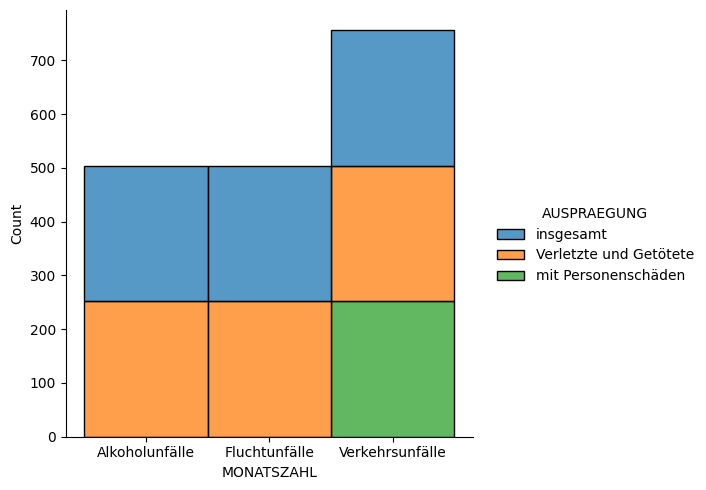

In [97]:
# Value Counts using stacked bar plots
sns.displot(data=df_month, x='MONATSZAHL', hue='AUSPRAEGUNG', multiple='stack')
plt.show()

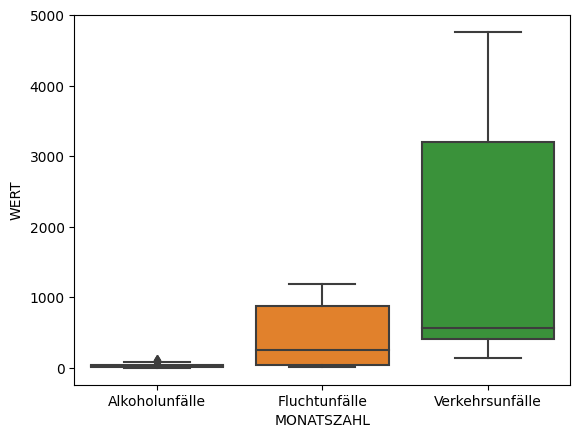

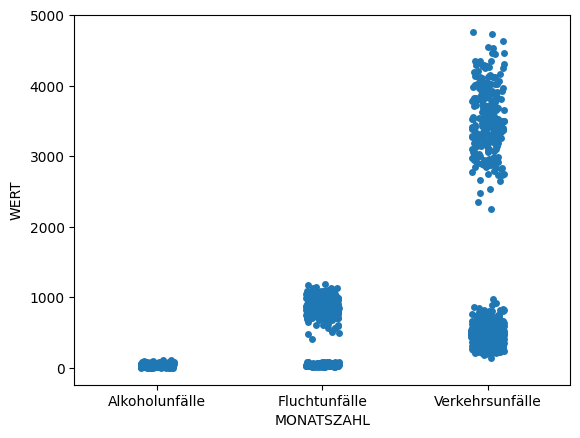

'\nInferences from Strip Plot:-\n1. Escape and Traffic Accidents making 2 clusters. \nNeed to go into detail what factor/variable in causing this clustering\n'

In [51]:
# Box Plot of values category wise: Primitive
sns.boxplot(data=df_month, x='MONATSZAHL', y='WERT')
plt.show()

'''
Inferences from Box Plot:- 
1. Distribution variation different for every Category (Order: Alcohol<Escape<Traffic)
2. Increasing Order of Means same as above
''' 

# Strip Plot of values category wise: Gives better understanding
sns.stripplot(data=df_month, x='MONATSZAHL', y='WERT')
plt.show()

'''
Inferences from Strip Plot:-
1. Escape and Traffic Accidents making 2 clusters. 
Need to go into detail what factor/variable in causing this clustering
'''

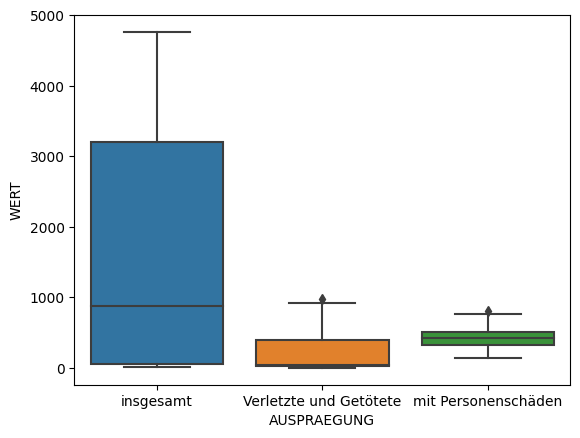

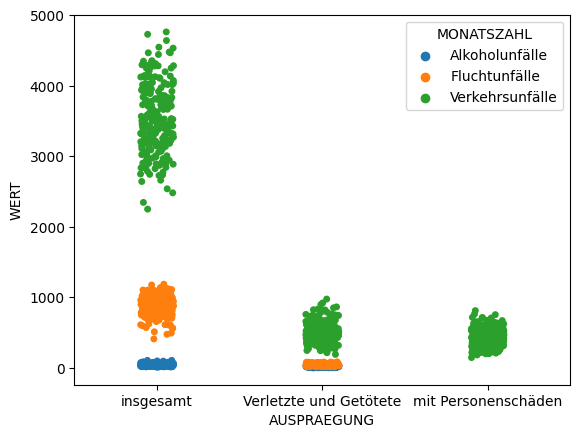

'\nInferences:-\n1. Distribution variation similar for Injured & Killed, Personal Injury. Total Distribution more variation.\n2. Increasing Order of Means: Injured & Killed < Personal Injury < Total\n'

In [52]:
# Box Plot of values accident-type wise
sns.boxplot(data=df_month, x='AUSPRAEGUNG', y='WERT')
plt.show()

'''
Inferences:-
1. Distribution variation similar for Injured & Killed, Personal Injury. Total Distribution more variation.
2. Increasing Order of Means: Injured & Killed < Personal Injury < Total
'''

# Strip Plot of values accident-type wise
sns.stripplot(data=df_month, x='AUSPRAEGUNG', y='WERT', hue = 'MONATSZAHL')
plt.show()

'''
Inferences:-
1. 'Total' accident-type has visibly separate clusters denoting each Category.
2. For 'Injured & Killed', Alcohol and Escape Accident clusters overlapping.
3. 'Personal Injury' has only one cluster: Traffic Accident Category.
'''

## Time-Series Analysis

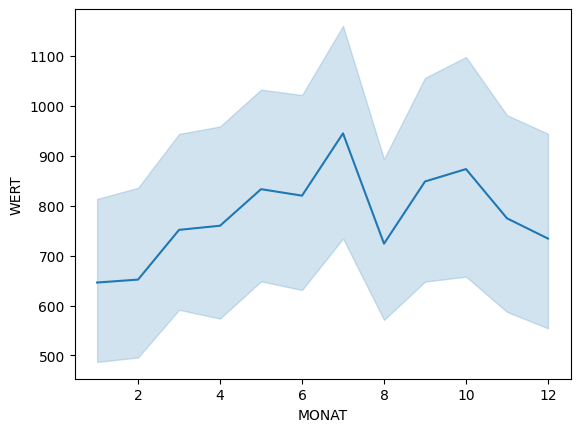

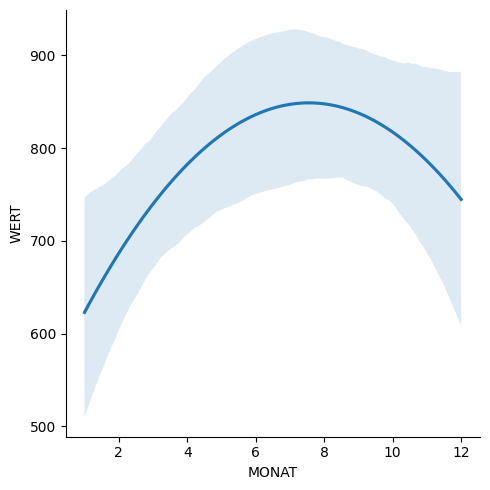

In [86]:
# Month-Wise Distribution: Line/Regression Plot
sns.lineplot(data=df_month, x='MONAT', y='WERT')
plt.show()

'''
Inference:-
1. Stable Increasing trend for more than half a year (first half)
2. Irregular decreasing trend after July(7)
Might help making a regression plot here that prevents overfitting
'''

sns.lmplot(data=df_month, x='MONAT', y='WERT', order=2, scatter=False)
plt.show()

'''
Inferences:-
1. Regression Plot of order 2 shows a parabolic shape peaking around July as we expected.
'''

Alkoholunfälle and insgesamt


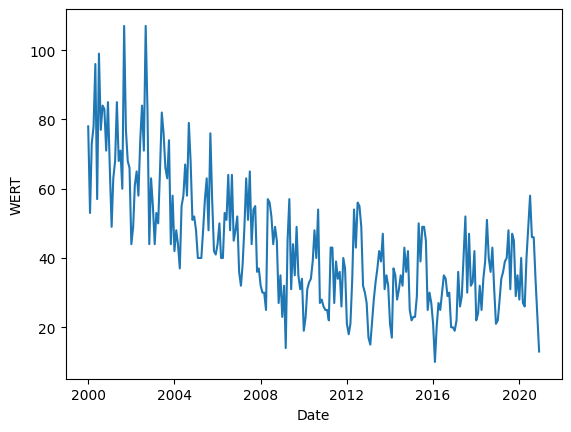

Alkoholunfälle and Verletzte und Getötete


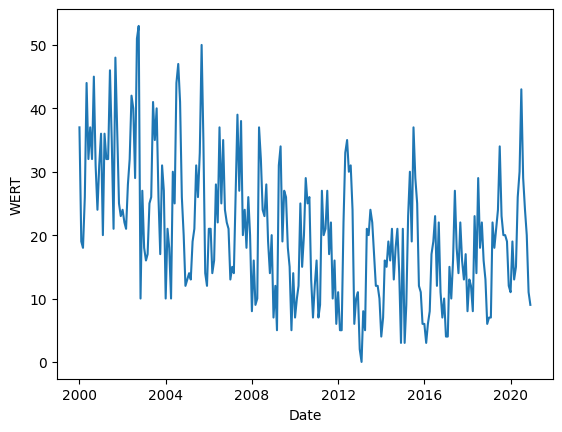

Fluchtunfälle and insgesamt


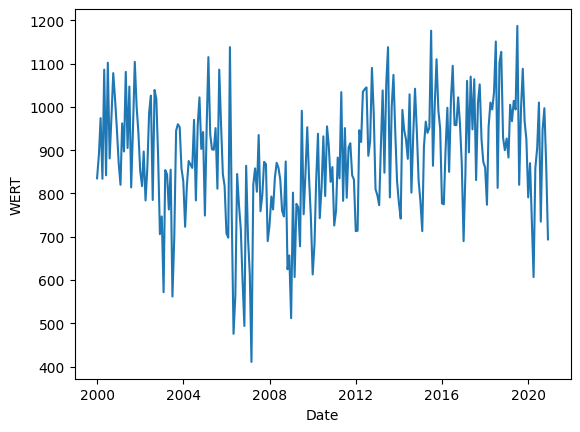

Fluchtunfälle and Verletzte und Getötete


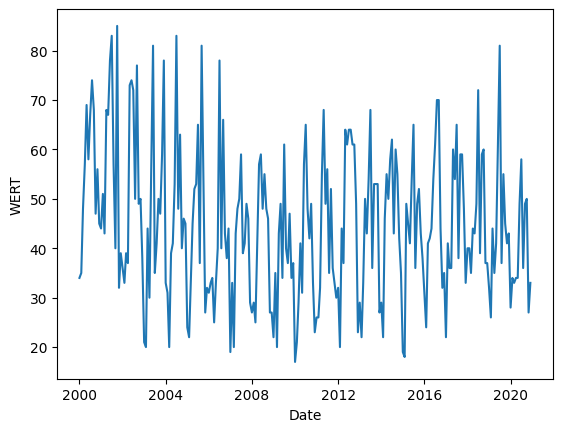

Verkehrsunfälle and insgesamt


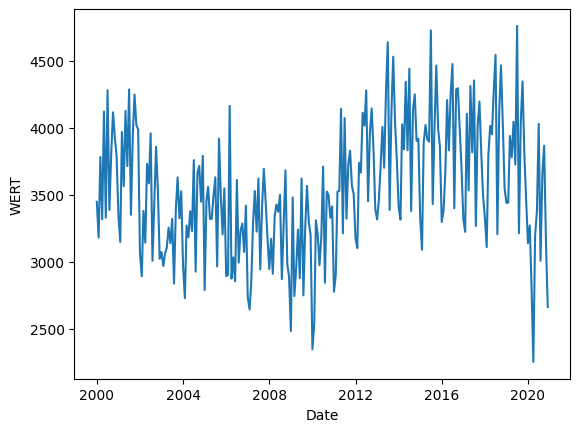

Verkehrsunfälle and mit Personenschäden


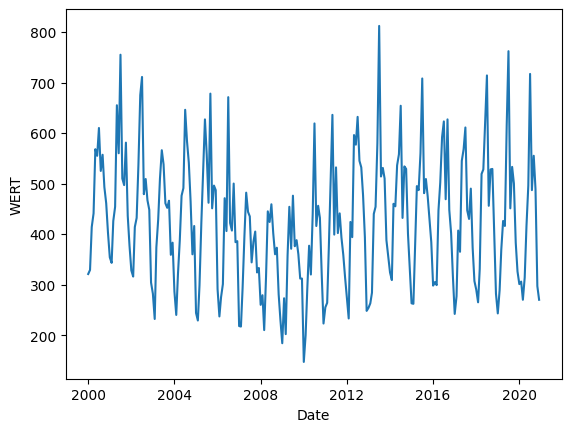

Verkehrsunfälle and Verletzte und Getötete


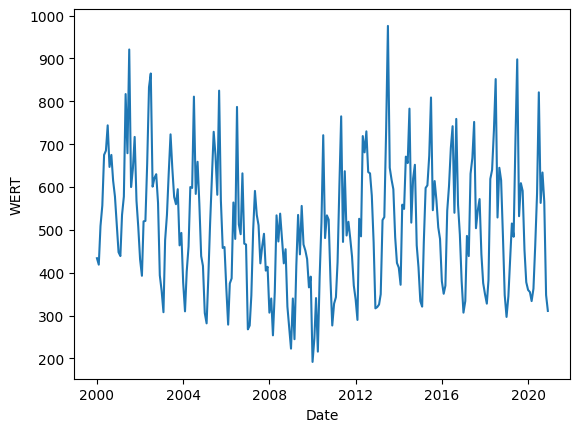

In [106]:
# Time-Series Line plot for every Category & Accident-Type pair
temp = df_month.copy()
temp['MONAT'] = temp['MONAT'].apply(lambda x: '0'+str(x) if x<10 else str(x))
temp['Date'] = temp.apply(lambda x: str(x['JAHR']) + str(x['MONAT']) + '01', axis = 1)
temp['Date'] = pd.to_datetime(temp['Date'])

for cat in df_month['MONATSZAHL'].unique():
    for acc in temp[temp['MONATSZAHL'] == cat]['AUSPRAEGUNG'].unique():
        print(cat, 'and', acc)
        temp2=temp[(temp['MONATSZAHL'] == cat) & (temp['AUSPRAEGUNG'] == acc)]
#         print(temp2.shape) # (252,6)
        sns.lineplot(data = temp2, x='Date', y='WERT')
        plt.show()
#         temp2['Date'] = pd.to_numeric(temp2['Date'])
#         sns.lmplot(data = temp2, x='Date', y='WERT', x_bins=5)
#         plt.show()

In [172]:
# Check if the Time-Series are stationary or not
temp = df_month.copy()
temp['MONAT'] = temp['MONAT'].apply(lambda x: '0'+str(x) if x<10 else str(x))
temp['Date'] = temp.apply(lambda x: str(x['JAHR']) + str(x['MONAT']) + '01', axis = 1)
temp['Date'] = pd.to_datetime(temp['Date'])

temp_log = temp.copy()
temp_log['WERT'] = np.log(temp_log['WERT'])
temp_log_diff = temp_log.copy()
temp_log_diff['WERT'] = temp_log_diff['WERT'].diff()

def augmented_dickey_fuller_statistics(time_series):
    try:
        result = adfuller(time_series['WERT'].values)
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
    except:
        time_series['WERT'] = time_series['WERT'].replace(-np.inf, 0)
        time_series['WERT'] = time_series['WERT'].replace(np.inf, 0)
        augmented_dickey_fuller_statistics(time_series)
        

for cat in df_month['MONATSZAHL'].unique():
    for acc in temp[temp['MONATSZAHL'] == cat]['AUSPRAEGUNG'].unique():
        print(cat, 'and', acc)
        temp2=temp_log[(temp_log['MONATSZAHL'] == cat) & (temp_log['AUSPRAEGUNG'] == acc)]
        temp3=temp_log_diff[(temp_log_diff['MONATSZAHL'] == cat) & (temp_log_diff['AUSPRAEGUNG'] == acc)]
        
        temp2.dropna(inplace = True)
        temp3.dropna(inplace = True)
        
        augmented_dickey_fuller_statistics(temp2)
        print('1st Order Difference')
        augmented_dickey_fuller_statistics(temp3)
        print()

'''
Inferences:-
1. None of the Time-Series are stationary since the p-value is coming >0.05
2. They all have stationary differences
Now we can check for cointegrating relationships (Note: Non-Stationary series is said to be cointegrated if there 
exists atleast one linear combination of these variables that is stationary)
'''

/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/682337221.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2.dropna(inplace = True)
/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/682337221.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp3.dropna(inplace = True)
/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/682337221.py:29: SettingWithCopyWarning: 
A value is trying to be set on a

Alkoholunfälle and insgesamt
ADF Statistic: 0.90354663150075
p-value: 0.9931364367109975
1st Order Difference
ADF Statistic: -7.433747189748192
p-value: 6.261716838143453e-11

Alkoholunfälle and Verletzte und Getötete
ADF Statistic: -0.5150978798831161
p-value: 0.8890364200602097
1st Order Difference
ADF Statistic: -4.831472911429865
p-value: 4.732735423553238e-05

Fluchtunfälle and insgesamt
ADF Statistic: -1.877586942679365
p-value: 0.34267725378944963
1st Order Difference
ADF Statistic: -9.993839907028521
p-value: 1.9638808385886312e-17

Fluchtunfälle and Verletzte und Getötete
ADF Statistic: -1.2911054698543771
p-value: 0.6332316840310178
1st Order Difference
ADF Statistic: -12.901925533092736
p-value: 4.2303704427065584e-24

Verkehrsunfälle and insgesamt
ADF Statistic: -1.3992117551289582
p-value: 0.5826539546268907
1st Order Difference
ADF Statistic: -6.03102494676217
p-value: 1.4179027851282848e-07

Verkehrsunfälle and mit Personenschäden
ADF Statistic: -0.9723006732026998
p-val

'\nInferences:-\n1. None of the Time-Series are stationary since the p-value is coming >0.05\n2. They all have stationary differences\nNow we can check for cointegrating relationships (Note: Non-Stationary series is said to be cointegrated if there \nexists atleast one linear combination of these variables that is stationary)\n'

In [162]:
# Johansen Cointegration Test
temp = df_new.copy()
temp_log = np.log(temp)

temp_log = temp_log.replace(-np.inf, 0)
temp_log = temp_log.replace(np.inf, 0)

vec_rank1 = vecm.select_coint_rank(temp_log, det_order = 0, k_ar_diff = 1, method = 'trace', signif = 0.05)
print(vec_rank1.summary())
print()
vec_rank2 = vecm.select_coint_rank(temp_log, det_order = 1, k_ar_diff = 1, method = 'trace', signif = 0.05)
print(vec_rank2.summary())

'''
Inferences:-
1. Since trace statistic > critical value for all rows in the summary, we can reject the null hypothesis.
Thus, cointegration relationships exist.
'''

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   7          497.8          125.6
  1   7          379.0          95.75
  2   7          276.7          69.82
  3   7          189.2          47.85
  4   7          112.7          29.80
  5   7          56.49          15.49
  6   7          14.86          3.841
-------------------------------------

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   7          557.7          139.3
  1   7          438.3          107.3
  2   7          335.0          79.34
  3   7          244.6          55.25
  4   7          165.2          35.01
  5   7          91.78          18.40
  6   7          39.43          3.841
-------------------------------------


Alkoholunfälle and insgesamt


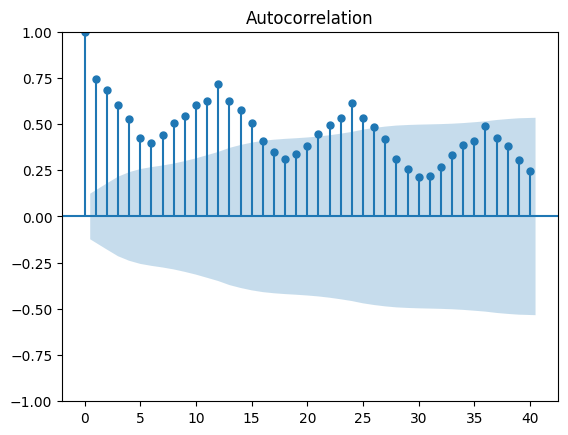

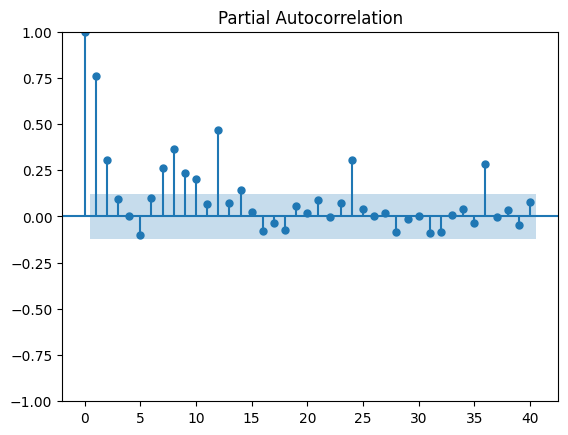

Alkoholunfälle and Verletzte und Getötete


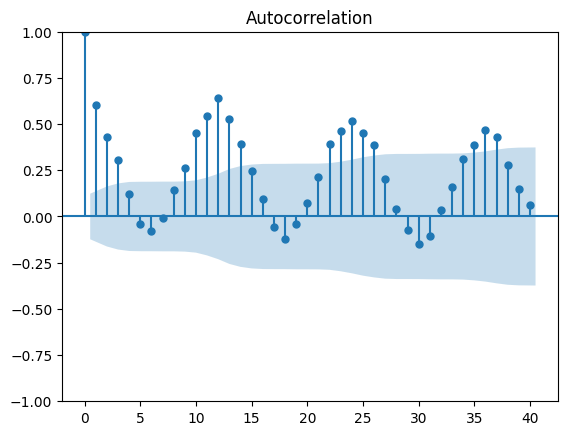

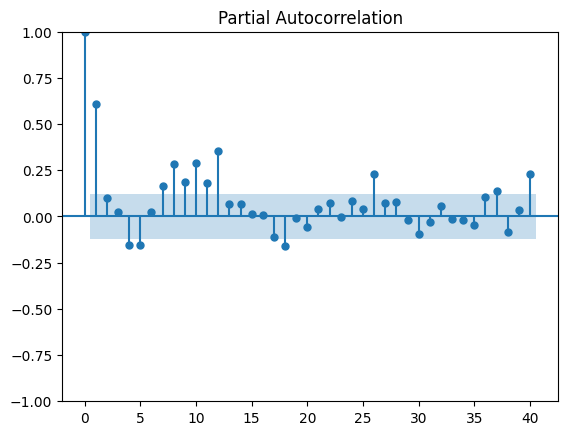

Fluchtunfälle and insgesamt


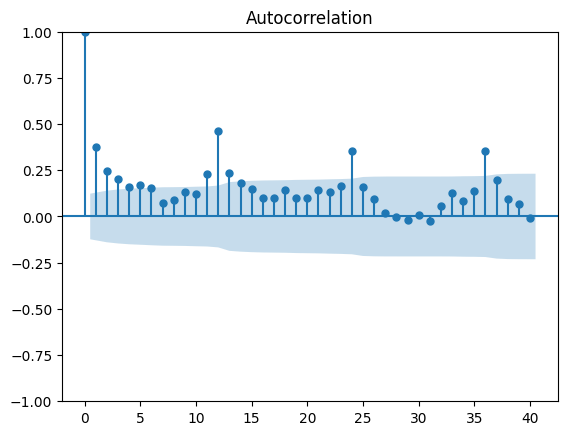

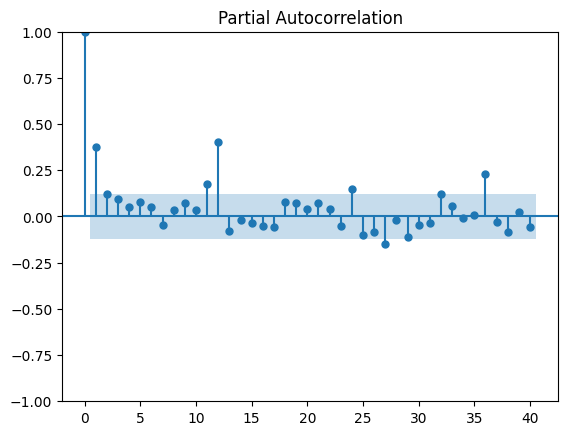

Fluchtunfälle and Verletzte und Getötete


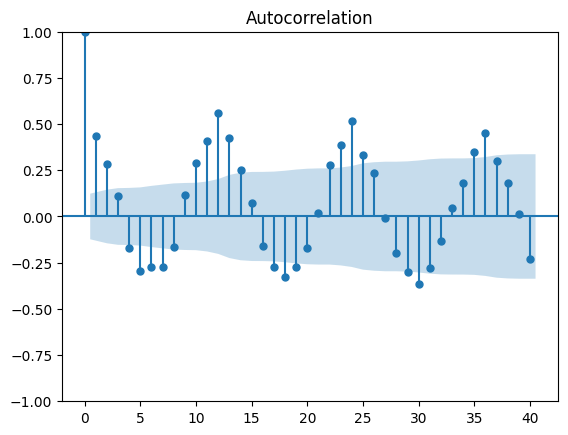

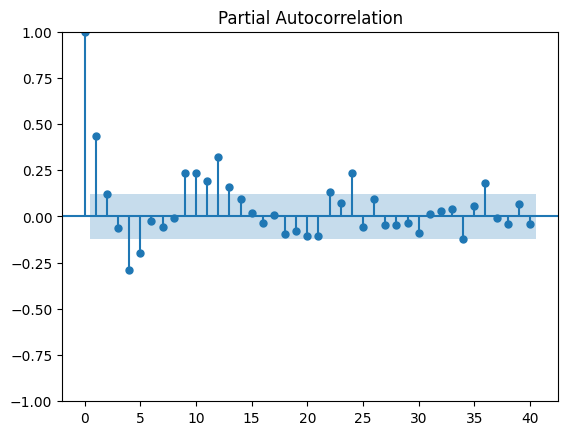

Verkehrsunfälle and insgesamt


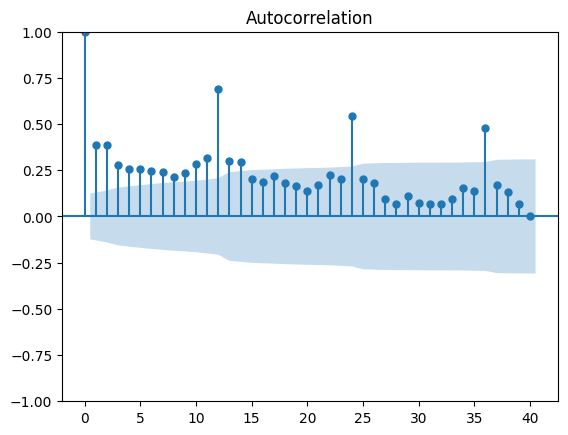

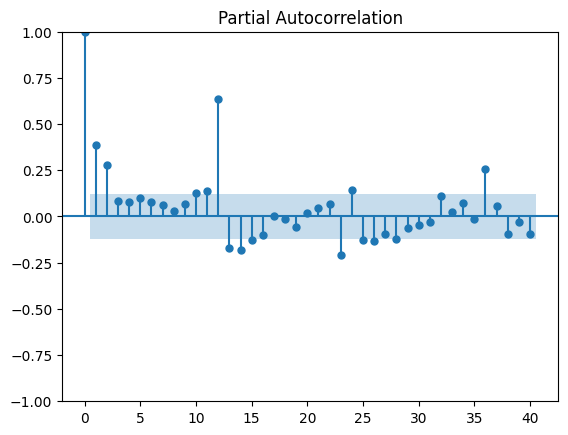

Verkehrsunfälle and mit Personenschäden


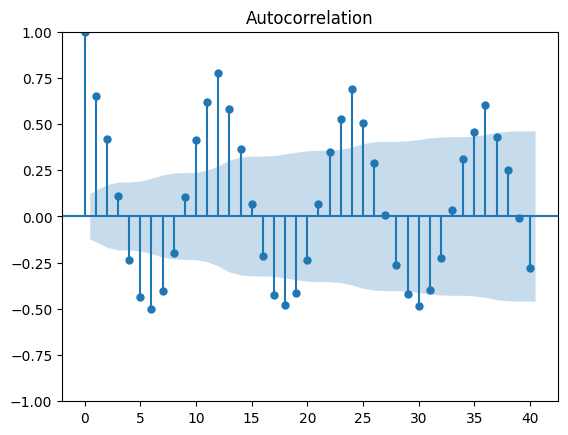

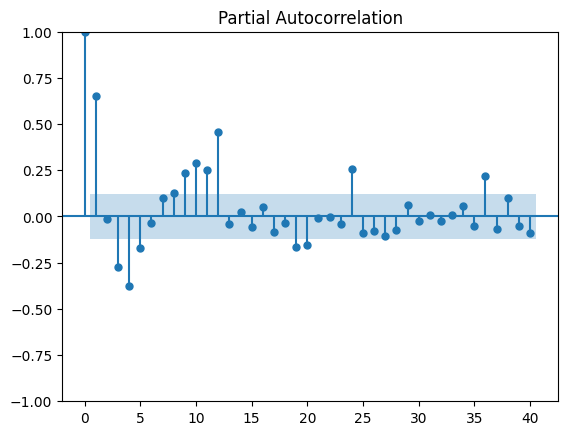

Verkehrsunfälle and Verletzte und Getötete


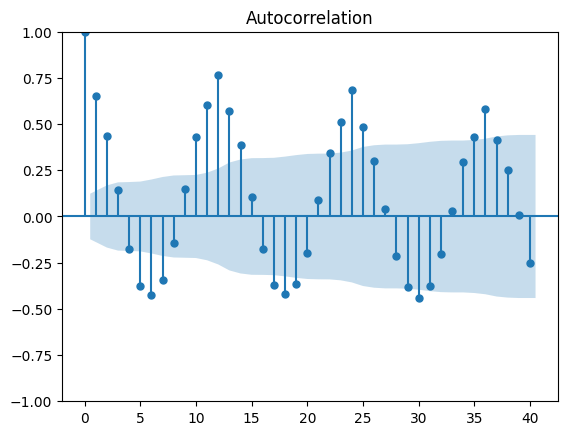

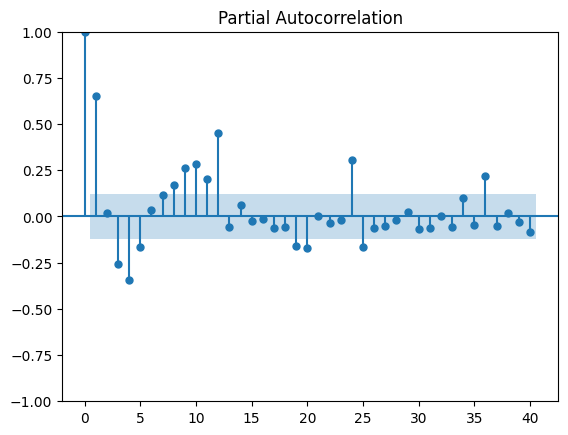

'\nInferences:-\n1. ACF tails off, PACF cuts off.\n2. At an average, our Auto-Regression model should be of window somewhere between 10-15 lags. \nThat is when the correlation effect starts to get lesser and lesser as the lags increase.\n'

In [251]:
# Plot Partial Auto-Correlation Function in Time-Series
temp = df_month.copy()
temp['MONAT'] = temp['MONAT'].apply(lambda x: '0'+str(x) if x<10 else str(x))
temp['Date'] = temp.apply(lambda x: str(x['JAHR']) + str(x['MONAT']) + '01', axis = 1)
temp['Date'] = pd.to_datetime(temp['Date'])

for cat in df_month['MONATSZAHL'].unique():
    for acc in temp[temp['MONATSZAHL'] == cat]['AUSPRAEGUNG'].unique():
        print(cat, 'and', acc)
        temp2=temp[(temp['MONATSZAHL'] == cat) & (temp['AUSPRAEGUNG'] == acc)]
        plot_acf(temp2['WERT'].values.squeeze(), lags=40)
        plot_pacf(temp2['WERT'].values.squeeze(), lags=40, method='ols')
        plt.show()

'''
Inferences:-
1. ACF tails off, PACF cuts off.
2. At an average, our Auto-Regression model should be of window somewhere between 10-15 lags. 
That is when the correlation effect starts to get lesser and lesser as the lags increase.
'''

Alkoholunfälle and insgesamt


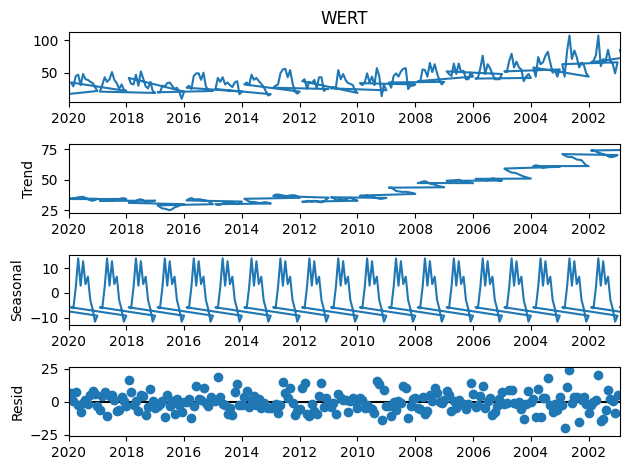

Alkoholunfälle and Verletzte und Getötete


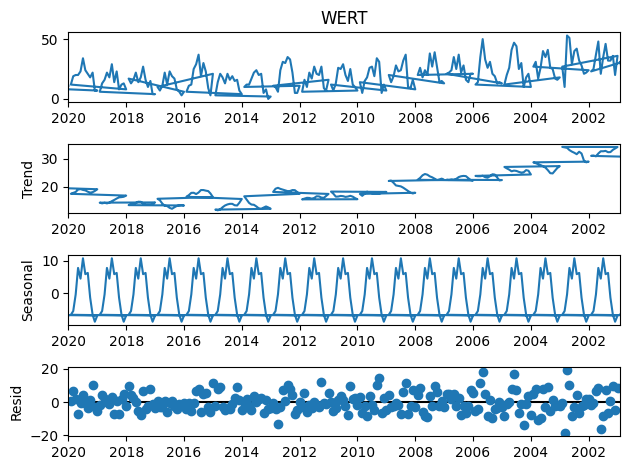

Fluchtunfälle and insgesamt


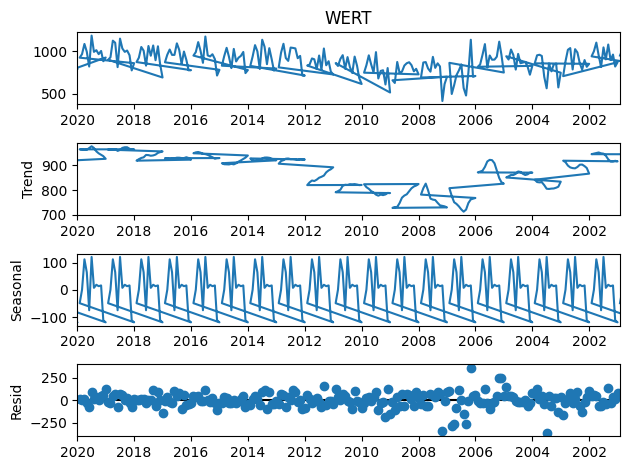

Fluchtunfälle and Verletzte und Getötete


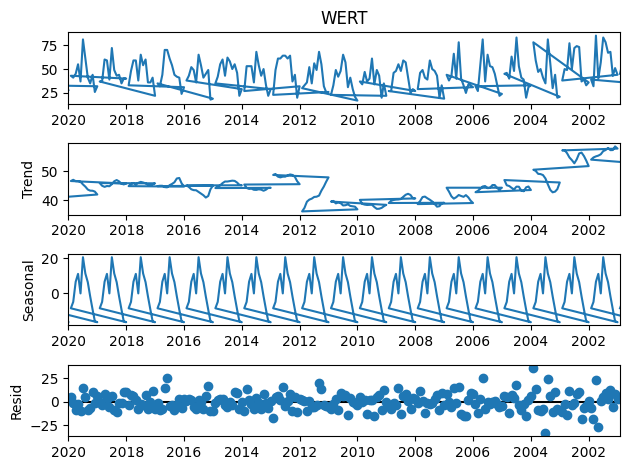

Verkehrsunfälle and insgesamt


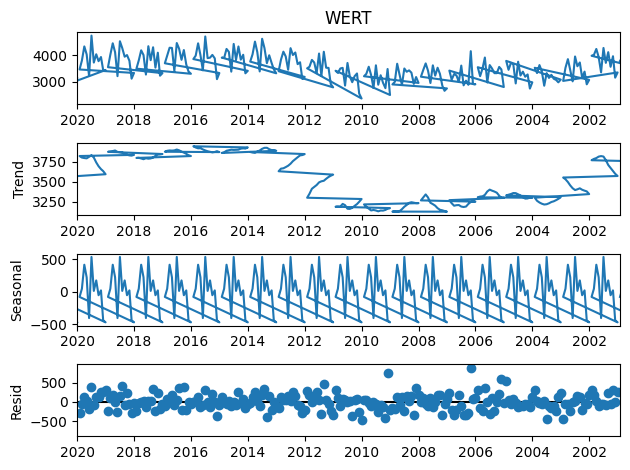

Verkehrsunfälle and mit Personenschäden


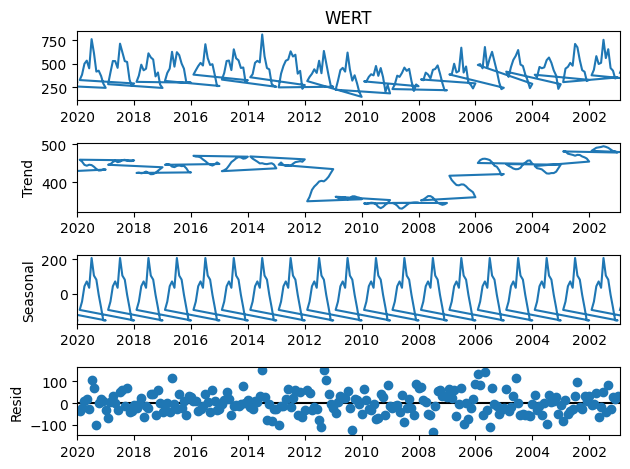

Verkehrsunfälle and Verletzte und Getötete


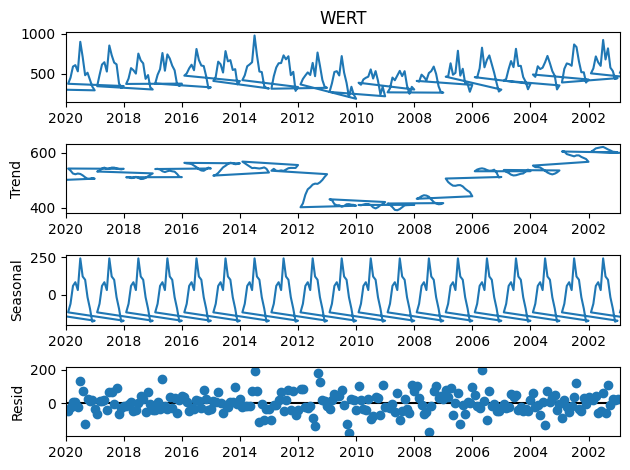

In [119]:
# Trend and Seasonality check
temp = df_month.copy()
temp['MONAT'] = temp['MONAT'].apply(lambda x: '0'+str(x) if x<10 else str(x))
temp['Date'] = temp.apply(lambda x: str(x['JAHR']) + str(x['MONAT']) + '01', axis = 1)
temp['Date'] = pd.to_datetime(temp['Date'])

for cat in df_month['MONATSZAHL'].unique():
    for acc in temp[temp['MONATSZAHL'] == cat]['AUSPRAEGUNG'].unique():
        print(cat, 'and', acc)
        temp2=temp[(temp['MONATSZAHL'] == cat) & (temp['AUSPRAEGUNG'] == acc)]
        temp2 = temp2.set_index('Date')
        result = seasonal_decompose(temp2['WERT'], model='additive', period=12)
        result.plot()
        plt.show()

'''
Inferences:-
1. Trend with Alcohol Accidents is generally increasing.
2. Trend for all other types of accidents is first increasing, then decreasing and finally increasing again.
'''

# Modelling

## ARIMA

In [248]:
# Selecting best Order values
cols = df_new.columns
for col in cols:
    print('#######',col,'########')
    stepwise_fit = auto_arima(df_new[col], trace = True)
    stepwise_fit.summary()
    print()

####### Alkoholunfälle and insgesamt ########
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1927.066, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1997.543, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1959.851, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1956.164, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1995.645, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1960.127, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1925.567, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1927.558, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1958.829, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1925.646, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1960.820, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1929.547, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1927.933, Time=0.16 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total 

 ARIMA(2,0,5)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(4,0,5)(0,0,0)[0]             : AIC=inf, Time=0.76 sec

Best model:  ARIMA(3,0,4)(0,0,0)[0]          
Total fit time: 14.522 seconds



Alkoholunfälle and insgesamt


/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10.749665459844213


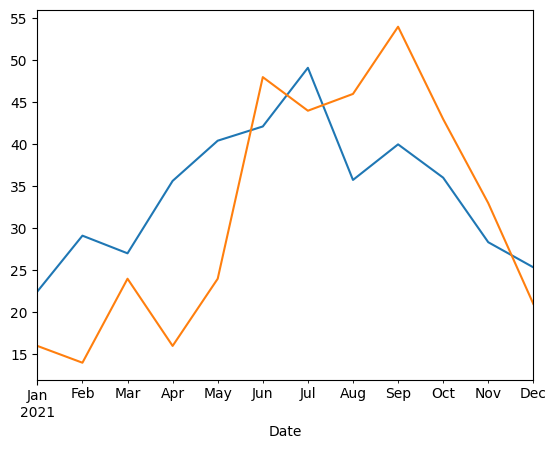

Alkoholunfälle and Verletzte und Getötete


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8.55673846281317


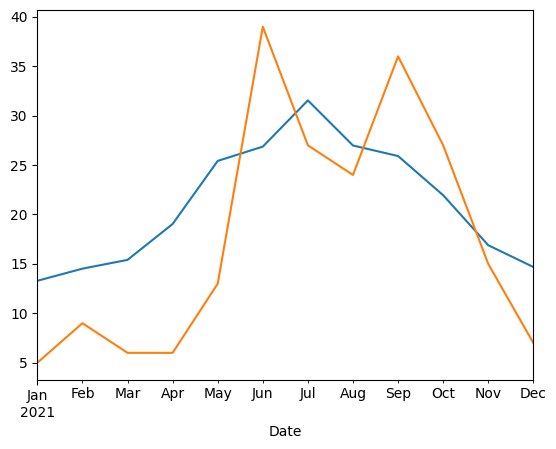

Fluchtunfälle and insgesamt


/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


119.85712032903943


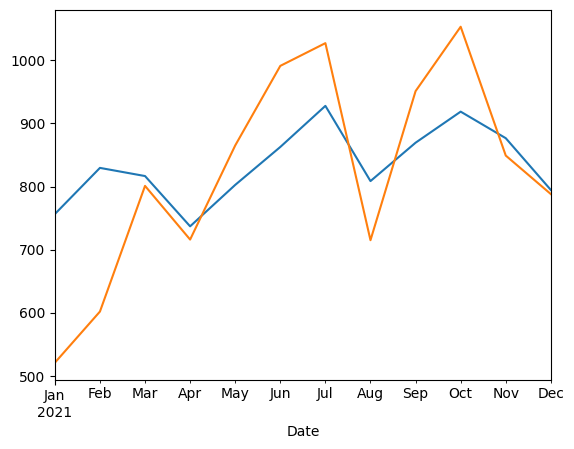

Fluchtunfälle and Verletzte und Getötete


/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16.330702906031284


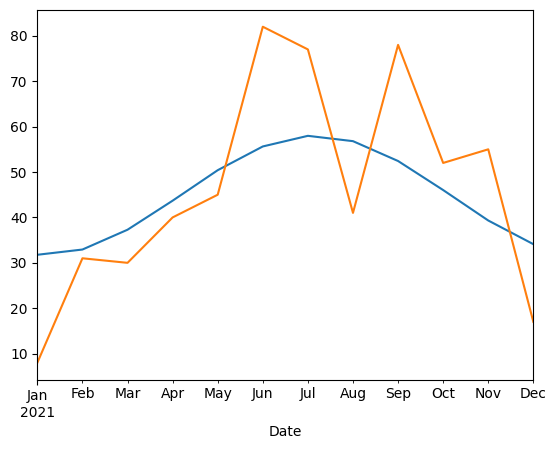

Verkehrsunfälle and insgesamt


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


364.02320587667765


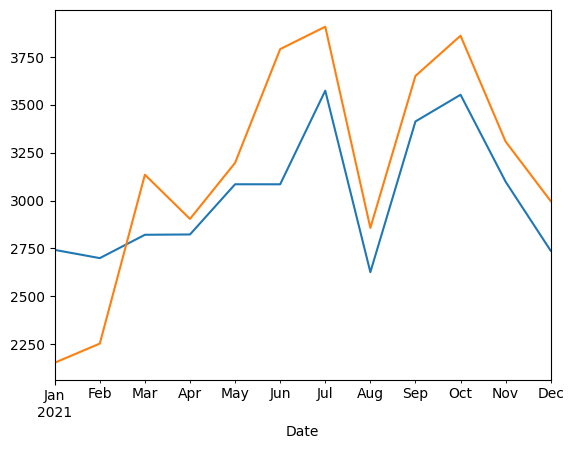

Verkehrsunfälle and mit Personenschäden


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


63.00209713497466


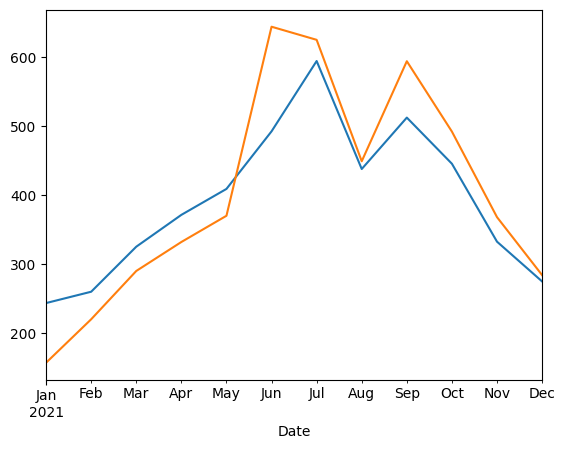

Verkehrsunfälle and Verletzte und Getötete


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


86.55810641566794


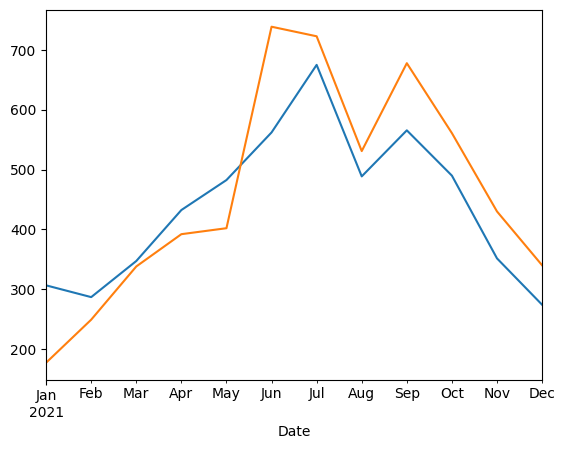

In [267]:
# Training & Testing model
best_params = [(12,1,15),(13,1,13),(12,1,4),(2,0,2),(15,1,14),(12,1,14),(13,1,14)]
for i in range(len(cols)):
    print(cols[i])
    model = ARIMA(df_new[cols[i]], order = best_params[i])
    model = model.fit()
#     display(model.summary())
#     pred = model.predict(n_periods=12)
    pred = model.predict(start = df_new.shape[0], end = df_new.shape[0] + test_df_new.shape[0] - 1, type='levels')
    pred.index = test_df_new.index
#     display(test_df_new[cols[i]])
#     display(pred)
    print(rmse(test_df_new[cols[i]], pred))
    pred.plot()
    test_df_new[cols[i]].plot()
    plt.show()

## LSTM

In [293]:
scaler = MinMaxScaler()
def lstm_output(col):
    print(col)
    temp_train = df_new[[col]]
    temp_test = test_df_new[[col]]
    
    scaler.fit(temp_train)
    scaled_train = scaler.transform(temp_train)
    
    n_input = 180
    generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)
    
    model = Sequential()
    model.add(LSTM(100, activation = 'relu', input_shape = (n_input, 1)))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mse')
    model.fit(generator, epochs = 20)
    
    loss_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
    plt.show()
    
    test_predictions = []
    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, 1))
    
    for i in range(len(temp_test)):
        current_pred = model.predict(current_batch)[0]
        test_predictions.append(current_pred)
        current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)
    
    true_predictions = scaler.inverse_transform(test_predictions)
    temp_test['value'] = true_predictions
    
    temp_test.plot()
    plt.show()
    
    print(rmse(temp_test[col], temp_test['value']))
    return temp_test

Alkoholunfälle and insgesamt
Epoch 1/20
72/72 [==============================] - 8s 70ms/step - loss: 0.0161
Epoch 2/20
72/72 [==============================] - 5s 71ms/step - loss: 0.0114
Epoch 3/20
72/72 [==============================] - 5s 70ms/step - loss: 0.0116
Epoch 4/20
72/72 [==============================] - 5s 69ms/step - loss: 0.0110
Epoch 5/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0111
Epoch 6/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0103
Epoch 7/20
72/72 [==============================] - 5s 69ms/step - loss: 0.0112
Epoch 8/20
72/72 [==============================] - 5s 71ms/step - loss: 0.0107
Epoch 9/20
72/72 [==============================] - 5s 72ms/step - loss: 0.0098
Epoch 10/20
72/72 [==============================] - 7s 92ms/step - loss: 0.0103
Epoch 11/20
72/72 [==============================] - 5s 74ms/step - loss: 0.0093
Epoch 12/20
72/72 [==============================] - 6s 82ms/step - loss: 0.0084
Epoch 13

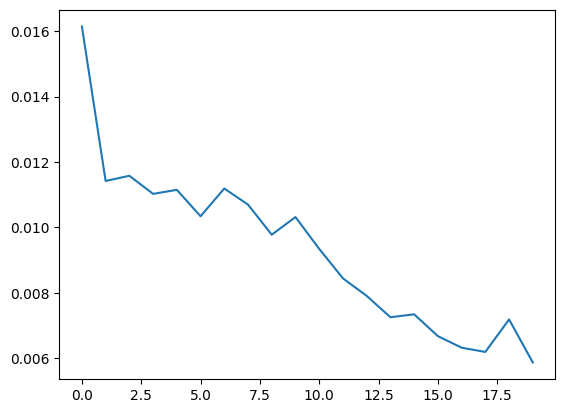

1/1 [==============================] - 0s 55ms/step


/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/1302932870.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_test['value'] = true_predictions


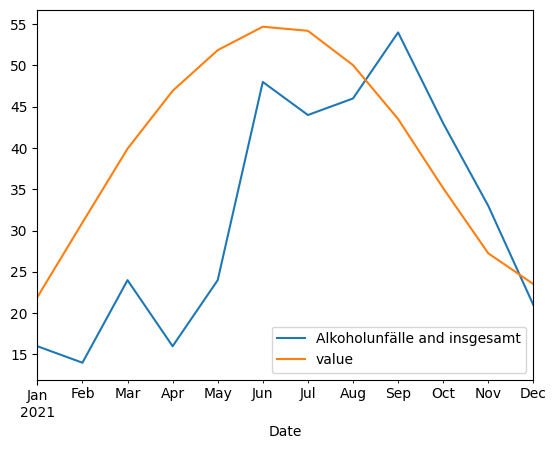

14.957342297085937


Alkoholunfälle and insgesamt      value
Date                                            
2021-01                          16.0  21.939562
2021-02                          14.0  30.970245
2021-03                          24.0  39.914321
2021-04                          16.0  46.923236
2021-05                          24.0  51.851339
2021-06                          48.0  54.691156
2021-07                          44.0  54.195203
2021-08                          46.0  50.044590
2021-09                          54.0  43.518226
2021-10                          43.0  35.141134
2021-11                          33.0  27.248598
2021-12                          21.0  23.531366

Alkoholunfälle and Verletzte und Getötete
Epoch 1/20
72/72 [==============================] - 7s 66ms/step - loss: 0.0353
Epoch 2/20
72/72 [==============================] - 5s 65ms/step - loss: 0.0254
Epoch 3/20
72/72 [==============================] - 5s 66ms/step - loss: 0.0275
Epoch 4/20
72/72 [==============================] - 5s 65ms/step - loss: 0.0250
Epoch 5/20
72/72 [==============================] - 5s 65ms/step - loss: 0.0255
Epoch 6/20
72/72 [==============================] - 5s 66ms/step - loss: 0.0247
Epoch 7/20
72/72 [==============================] - 5s 67ms/step - loss: 0.0242
Epoch 8/20
72/72 [==============================] - 5s 65ms/step - loss: 0.0233
Epoch 9/20
72/72 [==============================] - 5s 72ms/step - loss: 0.0242
Epoch 10/20
72/72 [==============================] - 5s 65ms/step - loss: 0.0230
Epoch 11/20
72/72 [==============================] - 5s 66ms/step - loss: 0.0232
Epoch 12/20
72/72 [==============================] - 5s 69ms/step - loss: 0.

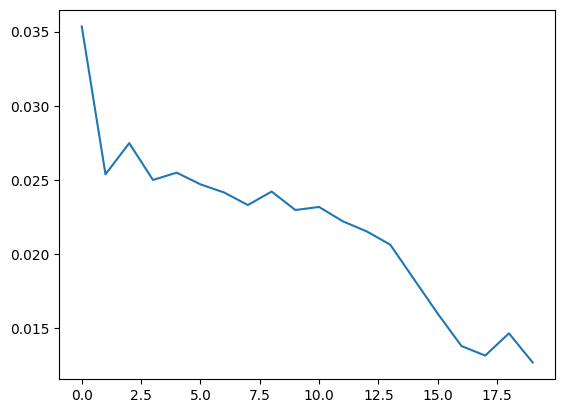

1/1 [==============================] - 0s 40ms/step


/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/1302932870.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_test['value'] = true_predictions


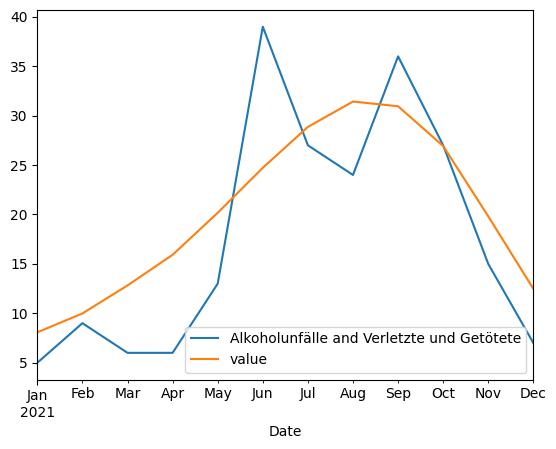

6.758265084158748


Alkoholunfälle and Verletzte und Getötete      value
Date                                                         
2021-01                                        5.0   8.076631
2021-02                                        9.0   9.988643
2021-03                                        6.0  12.822861
2021-04                                        6.0  15.923619
2021-05                                       13.0  20.172557
2021-06                                       39.0  24.724599
2021-07                                       27.0  28.863131
2021-08                                       24.0  31.429170
2021-09                                       36.0  30.950550
2021-10                                       27.0  26.930689
2021-11                                       15.0  19.813429
2021-12                                        7.0  12.481761

Fluchtunfälle and insgesamt
Epoch 1/20
72/72 [==============================] - 14s 88ms/step - loss: 0.0476
Epoch 2/20
72/72 [==============================] - 6s 84ms/step - loss: 0.0296
Epoch 3/20
72/72 [==============================] - 6s 81ms/step - loss: 0.0306
Epoch 4/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0256
Epoch 5/20
72/72 [==============================] - 5s 72ms/step - loss: 0.0281
Epoch 6/20
72/72 [==============================] - 5s 70ms/step - loss: 0.0253
Epoch 7/20
72/72 [==============================] - 5s 73ms/step - loss: 0.0272
Epoch 8/20
72/72 [==============================] - 7s 91ms/step - loss: 0.0309
Epoch 9/20
72/72 [==============================] - 8s 110ms/step - loss: 0.0252
Epoch 10/20
72/72 [==============================] - 10s 135ms/step - loss: 0.0267
Epoch 11/20
72/72 [==============================] - 12s 162ms/step - loss: 0.0261
Epoch 12/20
72/72 [==============================] - 9s 124ms/step - loss: 0.0255
Ep

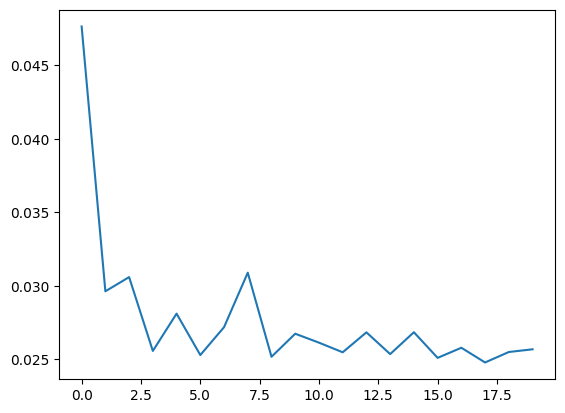

1/1 [==============================] - 0s 63ms/step


/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/1302932870.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_test['value'] = true_predictions


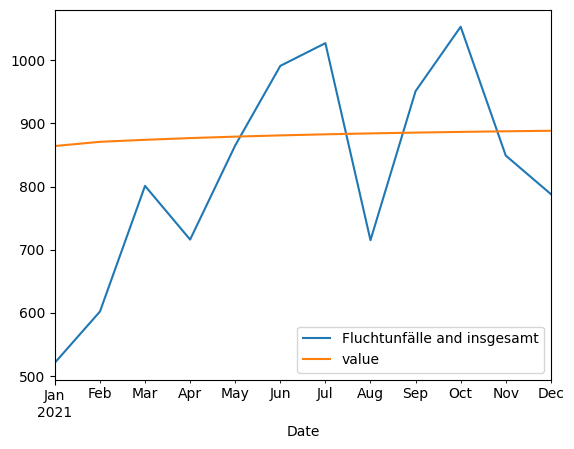

164.92679720936295


Fluchtunfälle and insgesamt       value
Date                                            
2021-01                        521.0  864.111561
2021-02                        602.0  870.763882
2021-03                        801.0  873.940135
2021-04                        716.0  876.672497
2021-05                        865.0  878.979145
2021-06                        991.0  880.946386
2021-07                       1027.0  882.636339
2021-08                        715.0  884.096692
2021-09                        951.0  885.364168
2021-10                       1053.0  886.467862
2021-11                        849.0  887.431501
2021-12                        788.0  888.274281

Fluchtunfälle and Verletzte und Getötete
Epoch 1/20
72/72 [==============================] - 13s 94ms/step - loss: 0.0598
Epoch 2/20
72/72 [==============================] - 8s 106ms/step - loss: 0.0414
Epoch 3/20
72/72 [==============================] - 6s 89ms/step - loss: 0.0398
Epoch 4/20
72/72 [==============================] - 11s 153ms/step - loss: 0.0402
Epoch 5/20
72/72 [==============================] - 7s 101ms/step - loss: 0.0387
Epoch 6/20
72/72 [==============================] - 7s 92ms/step - loss: 0.0387
Epoch 7/20
72/72 [==============================] - 7s 98ms/step - loss: 0.0382
Epoch 8/20
72/72 [==============================] - 6s 88ms/step - loss: 0.0369
Epoch 9/20
72/72 [==============================] - 6s 84ms/step - loss: 0.0380
Epoch 10/20
72/72 [==============================] - 7s 90ms/step - loss: 0.0378
Epoch 11/20
72/72 [==============================] - 7s 92ms/step - loss: 0.0376
Epoch 12/20
72/72 [==============================] - 6s 80ms/step - loss

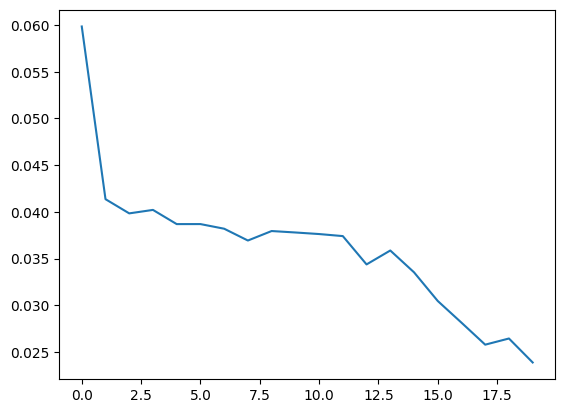

1/1 [==============================] - 0s 48ms/step


/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/1302932870.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_test['value'] = true_predictions


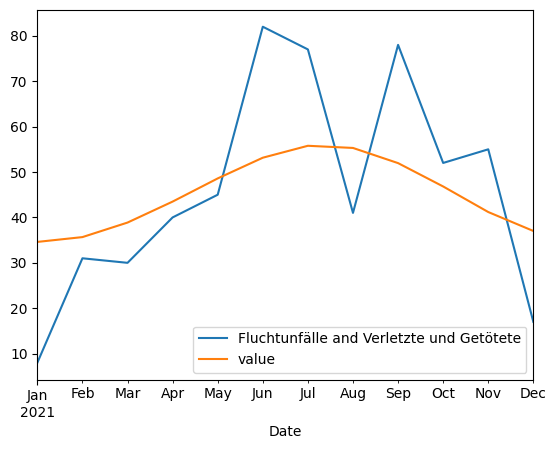

17.360996846101127


Fluchtunfälle and Verletzte und Getötete      value
Date                                                        
2021-01                                       8.0  34.606958
2021-02                                      31.0  35.667561
2021-03                                      30.0  38.868303
2021-04                                      40.0  43.488079
2021-05                                      45.0  48.589723
2021-06                                      82.0  53.151479
2021-07                                      77.0  55.779199
2021-08                                      41.0  55.301552
2021-09                                      78.0  51.960763
2021-10                                      52.0  46.816840
2021-11                                      55.0  41.187447
2021-12                                      17.0  37.016169

Verkehrsunfälle and insgesamt
Epoch 1/20
72/72 [==============================] - 9s 82ms/step - loss: 0.1328
Epoch 2/20
72/72 [==============================] - 6s 85ms/step - loss: 0.0419
Epoch 3/20
72/72 [==============================] - 6s 82ms/step - loss: 0.0406
Epoch 4/20
72/72 [==============================] - 6s 84ms/step - loss: 0.0417
Epoch 5/20
72/72 [==============================] - 6s 81ms/step - loss: 0.0395
Epoch 6/20
72/72 [==============================] - 6s 76ms/step - loss: 0.0394
Epoch 7/20
72/72 [==============================] - 6s 80ms/step - loss: 0.0440
Epoch 8/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0382
Epoch 9/20
72/72 [==============================] - 6s 86ms/step - loss: 0.0366
Epoch 10/20
72/72 [==============================] - 6s 87ms/step - loss: 0.0397
Epoch 11/20
72/72 [==============================] - 7s 91ms/step - loss: 0.0380
Epoch 12/20
72/72 [==============================] - 5s 72ms/step - loss: 0.0369
Epoch 1

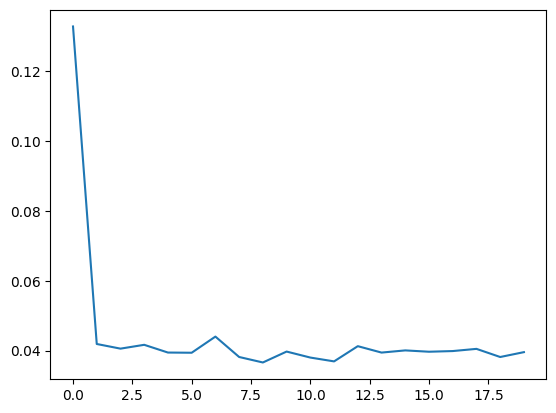

1/1 [==============================] - 0s 43ms/step


/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/1302932870.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_test['value'] = true_predictions


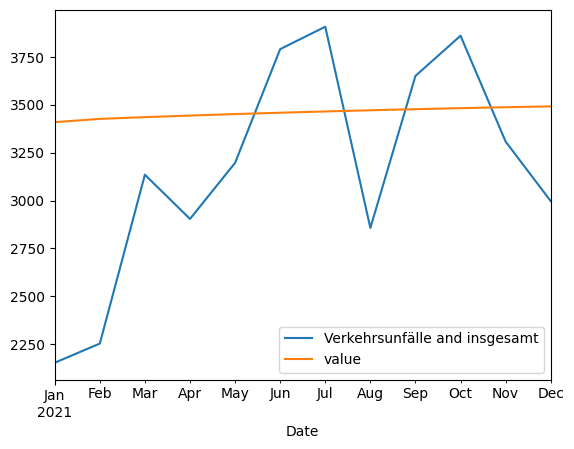

614.9494598668444


Verkehrsunfälle and insgesamt        value
Date                                               
2021-01                         2153.0  3409.622212
2021-02                         2253.0  3426.617409
2021-03                         3135.0  3435.705980
2021-04                         2904.0  3443.993886
2021-05                         3197.0  3451.655335
2021-06                         3791.0  3458.777842
2021-07                         3908.0  3465.409994
2021-08                         2857.0  3471.580986
2021-09                         3651.0  3477.312531
2021-10                         3861.0  3482.622819
2021-11                         3308.0  3487.529443
2021-12                         2997.0  3492.050820

Verkehrsunfälle and mit Personenschäden
Epoch 1/20
72/72 [==============================] - 10s 91ms/step - loss: 0.0813
Epoch 2/20
72/72 [==============================] - 6s 83ms/step - loss: 0.0419
Epoch 3/20
72/72 [==============================] - 6s 85ms/step - loss: 0.0419
Epoch 4/20
72/72 [==============================] - 6s 89ms/step - loss: 0.0437
Epoch 5/20
72/72 [==============================] - 7s 103ms/step - loss: 0.0412
Epoch 6/20
72/72 [==============================] - 6s 83ms/step - loss: 0.0417
Epoch 7/20
72/72 [==============================] - 7s 93ms/step - loss: 0.0379
Epoch 8/20
72/72 [==============================] - 6s 79ms/step - loss: 0.0377
Epoch 9/20
72/72 [==============================] - 6s 81ms/step - loss: 0.0371
Epoch 10/20
72/72 [==============================] - 6s 84ms/step - loss: 0.0341
Epoch 11/20
72/72 [==============================] - 7s 92ms/step - loss: 0.0321
Epoch 12/20
72/72 [==============================] - 7s 98ms/step - loss: 0.

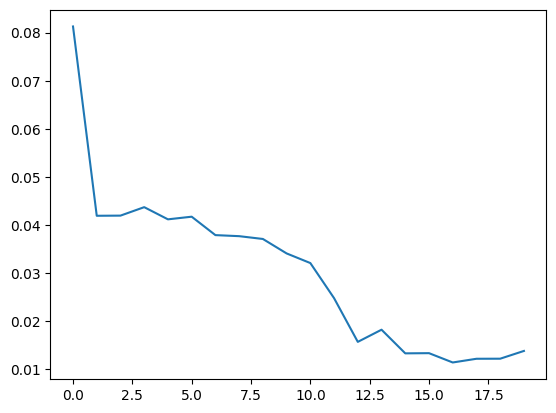

1/1 [==============================] - 0s 49ms/step


/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/1302932870.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_test['value'] = true_predictions


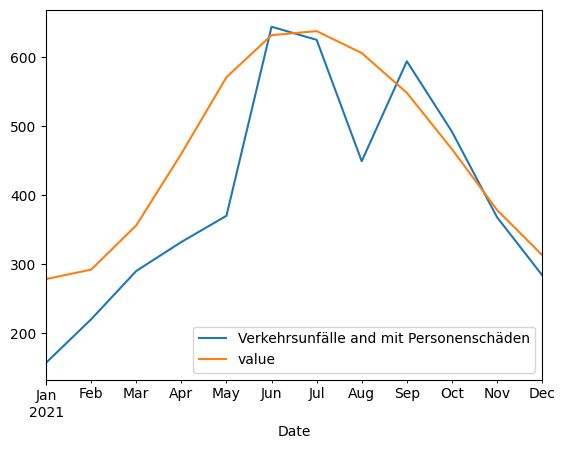

95.55963235802845


Verkehrsunfälle and mit Personenschäden       value
Date                                                        
2021-01                                    157.0  278.231187
2021-02                                    220.0  291.983334
2021-03                                    290.0  356.101478
2021-04                                    332.0  460.018490
2021-05                                    370.0  570.787307
2021-06                                    644.0  631.773328
2021-07                                    625.0  637.641956
2021-08                                    449.0  605.905609
2021-09                                    594.0  548.231941
2021-10                                    492.0  466.605778
2021-11                                    368.0  378.485216
2021-12                                    284.0  313.141632

Verkehrsunfälle and Verletzte und Getötete
Epoch 1/20
72/72 [==============================] - 11s 107ms/step - loss: 0.0656
Epoch 2/20
72/72 [==============================] - 6s 81ms/step - loss: 0.0424
Epoch 3/20
72/72 [==============================] - 6s 77ms/step - loss: 0.0389
Epoch 4/20
72/72 [==============================] - 5s 75ms/step - loss: 0.0379
Epoch 5/20
72/72 [==============================] - 5s 70ms/step - loss: 0.0387
Epoch 6/20
72/72 [==============================] - 6s 90ms/step - loss: 0.0354
Epoch 7/20
72/72 [==============================] - 6s 81ms/step - loss: 0.0365
Epoch 8/20
72/72 [==============================] - 6s 86ms/step - loss: 0.0321
Epoch 9/20
72/72 [==============================] - 6s 79ms/step - loss: 0.0293
Epoch 10/20
72/72 [==============================] - 6s 78ms/step - loss: 0.0202
Epoch 11/20
72/72 [==============================] - 6s 82ms/step - loss: 0.0158
Epoch 12/20
72/72 [==============================] - 6s 80ms/step - loss:

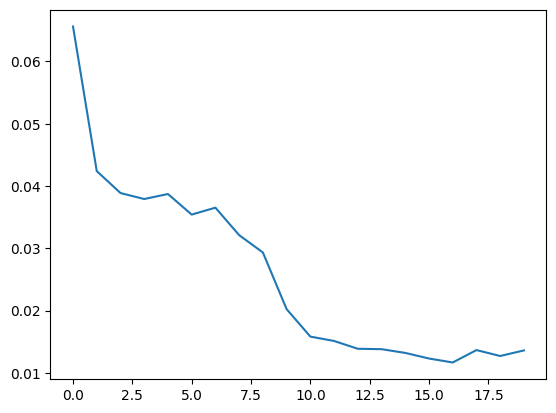

1/1 [==============================] - 0s 54ms/step


/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/1302932870.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_test['value'] = true_predictions


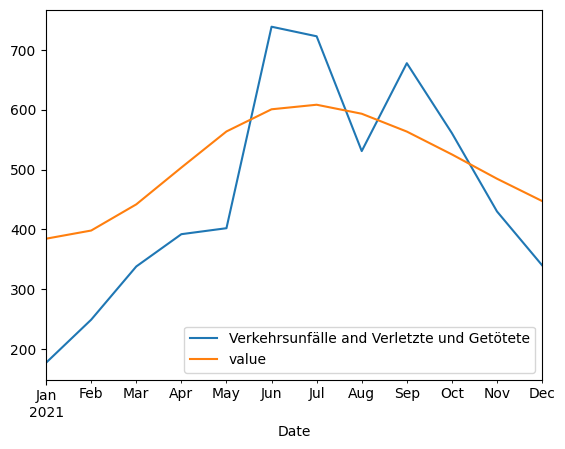

122.35174072973932


Verkehrsunfälle and Verletzte und Getötete       value
Date                                                           
2021-01                                       177.0  384.456169
2021-02                                       249.0  398.107334
2021-03                                       338.0  441.887215
2021-04                                       392.0  503.448951
2021-05                                       402.0  563.818931
2021-06                                       739.0  600.899546
2021-07                                       723.0  608.514019
2021-08                                       531.0  593.446712
2021-09                                       678.0  563.624650
2021-10                                       561.0  525.376859
2021-11                                       430.0  484.751724
2021-12                                       340.0  447.436898

In [294]:
for col in df_new.columns:
    pred = lstm_output(col)
    display(pred)

## XGBoost

In [322]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
#         print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = rmse(test[:, -1], predictions)
    return error, test[:, -1], predictions

RMSE: 9.522


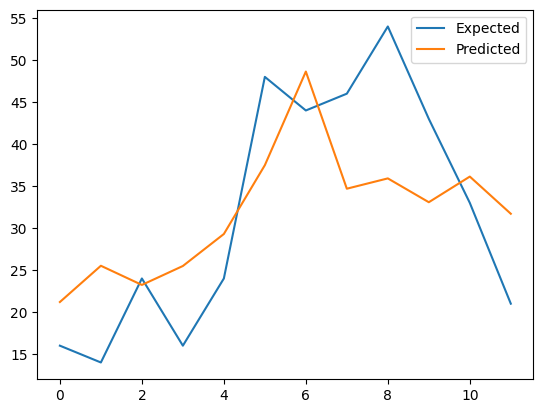

RMSE: 7.308


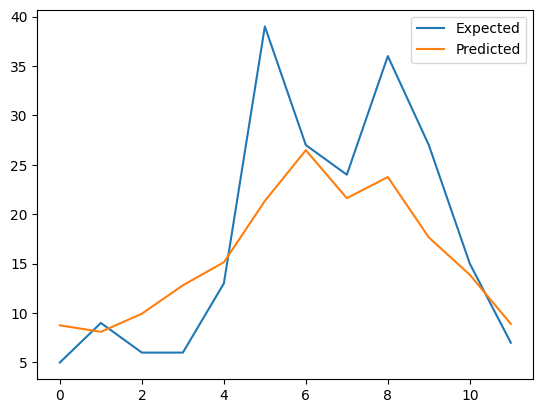

RMSE: 112.555


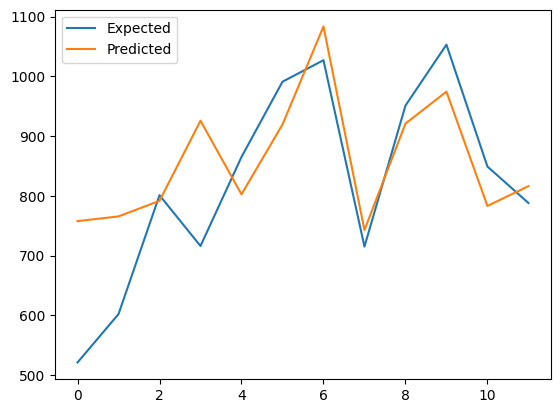

RMSE: 13.784


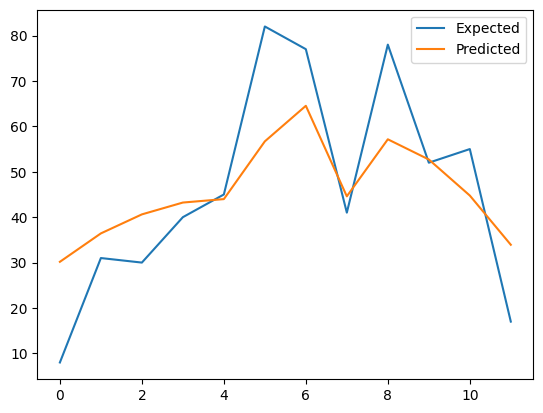

RMSE: 501.732


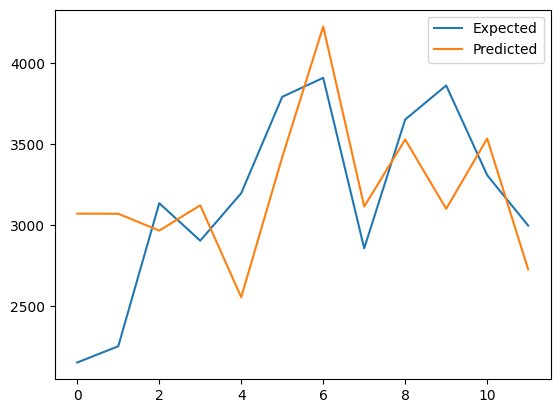

RMSE: 54.346


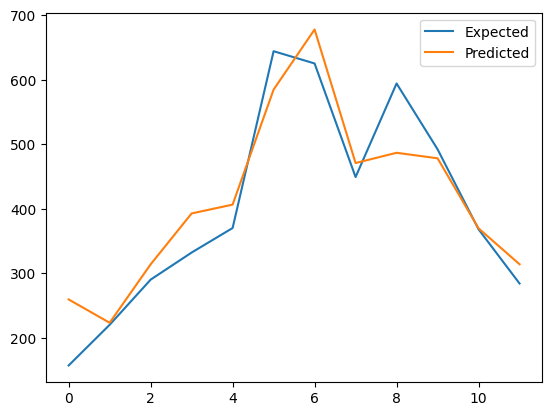

RMSE: 76.001


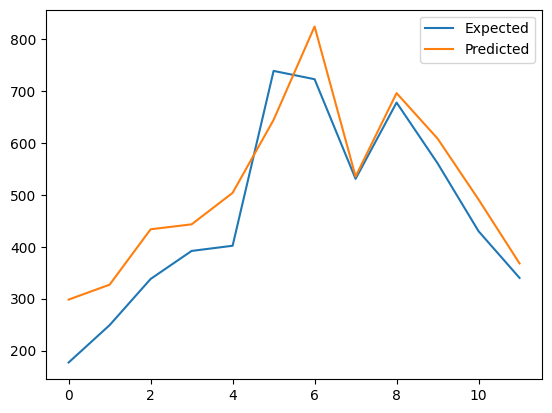

In [330]:
# Concatenate Train & Test data
temp = pd.concat([df_new, test_df_new])
inp_len = [180,60,120,120,180,180,60]
count = 0

for col in df_new.columns:
    series = temp[[col]]
    values = series.values
    # transform the time series data into supervised learning
    data = series_to_supervised(values, n_in=inp_len[count])
    count = count + 1
    # evaluate
    rms, y, yhat = walk_forward_validation(data, 12)
    print('RMSE: %.3f' % rms)
    # plot expected vs preducted
    plt.plot(y, label='Expected')
    plt.plot(yhat, label='Predicted')
    plt.legend()
    plt.show()

## DeepAR Joint Model
Modeling all series jointly, as if they are coming from single data generating process

In [299]:
# Initiate VAR model
temp = df_new.copy()
temp_log = np.log(temp)
temp_log = temp_log.replace(-np.inf, 0)
temp_log = temp_log.replace(np.inf, 0)
temp_log_diff = temp_log.diff().dropna()

model_var = vecm.VAR(endog = temp_log_diff)
res = model_var.select_order(15)
display(res.summary())

'''
I perform initial lag selection for VECM model based on VAR model.

Inferences:-
1. BIC suggests the choice of 1 lag.
'''

<class 'statsmodels.iolib.table.SimpleTable'>

'\nI perform initial lag selection for VECM model based on VAR model.\n\nInferences:-\n1. BIC suggests the choice of 1 lag.\n'

In [362]:
temp = pd.concat([df_new, test_df_new])
temp = temp.reset_index(drop=True).T.reset_index()
display(temp)

ts_code = temp['index'].astype('category').cat.codes.values
display(ts_code)

index       0       1       2       3  \
0                Alkoholunfälle and insgesamt    78.0    53.0    73.0    78.0   
1   Alkoholunfälle and Verletzte und Getötete    37.0    19.0    18.0    26.0   
2                 Fluchtunfälle and insgesamt   835.0   890.0   974.0   834.0   
3    Fluchtunfälle and Verletzte und Getötete    34.0    35.0    48.0    57.0   
4               Verkehrsunfälle and insgesamt  3448.0  3181.0  3783.0  3317.0   
5     Verkehrsunfälle and mit Personenschäden   321.0   329.0   414.0   441.0   
6  Verkehrsunfälle and Verletzte und Getötete   434.0   419.0   509.0   557.0   

        4       5       6       7       8  ...     254     255     256  \
0    96.0    57.0    99.0    77.0    84.0  ...    24.0    16.0    24.0   
1    44.0    32.0    37.0    32.0    45.0  ...     6.0     6.0    13.0   
2  1086.0   842.0  1102.0   881.0   978.0  ...   801.0   716.0   865.0   
3    69.0    58.0    67.0    74.0    68.0  ...    30.0    40.0    45.0   
4  4123.0  3329.0  4282.0  3387.0  3807.0  ...  3135.0  2904.0  3197.0   
5   568.0   555.0   610.0   525.0   557.0  ...   290.0   332.0   370.0   
6   675.0   685.0   744.0   647.0   675.0  ...   338.0   392.0   402.0   

      257     258     259     260     261     262     263  
0    48.0    44.0    46.0    54.0    43.0    33.0    21.0  
1    39.0    27.0    24.0    36.0    27.0    15.0     7.0  
2   991.0  1027.0   715.0   951.0  1053.0   849.0   788.0  
3    82.0    77.0    41.0    78.0    52.0    55.0    17.0  
4  3791.0  3908.0  2857.0  3651.0  3861.0  3308.0  2997.0  
5   644.0   625.0   449.0   594.0   492.0   368.0   284.0  
6   739.0   723.0   531.0   678.0   561.0   430.0   340.0  

[7 rows x 265 columns]

array([1, 0, 3, 2, 5, 6, 4], dtype=int8)

In [363]:
df_train = temp.iloc[:, 1:253].values
df_test = temp.iloc[:, 253:].values
display(df_train)
display(df_test)

array([[  78.,   53.,   73., ...,   34.,   23.,   13.],
       [  37.,   19.,   18., ...,   20.,   11.,    9.],
       [ 835.,  890.,  974., ...,  997.,  864.,  694.],
       ...,
       [3448., 3181., 3783., ..., 3867., 3150., 2661.],
       [ 321.,  329.,  414., ...,  489.,  297.,  270.],
       [ 434.,  419.,  509., ...,  566.,  348.,  311.]])

array([[  16.,   14.,   24.,   16.,   24.,   48.,   44.,   46.,   54.,
          43.,   33.,   21.],
       [   5.,    9.,    6.,    6.,   13.,   39.,   27.,   24.,   36.,
          27.,   15.,    7.],
       [ 521.,  602.,  801.,  716.,  865.,  991., 1027.,  715.,  951.,
        1053.,  849.,  788.],
       [   8.,   31.,   30.,   40.,   45.,   82.,   77.,   41.,   78.,
          52.,   55.,   17.],
       [2153., 2253., 3135., 2904., 3197., 3791., 3908., 2857., 3651.,
        3861., 3308., 2997.],
       [ 157.,  220.,  290.,  332.,  370.,  644.,  625.,  449.,  594.,
         492.,  368.,  284.],
       [ 177.,  249.,  338.,  392.,  402.,  739.,  723.,  531.,  678.,
         561.,  430.,  340.]])

In [364]:
freq = '1M'
start_train = pd.Timestamp("2000-01", freq=freq)
start_test = pd.Timestamp("2021-01", freq=freq)
prediction_length = 12
display(start_train)
display(start_test)

/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/3409610917.py:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_train = pd.Timestamp("2000-01", freq=freq)
/var/folders/vt/8vmvzc712931z9nsx9wnm7s80000gn/T/ipykernel_30551/3409610917.py:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_test = pd.Timestamp("2021-01", freq=freq)


Timestamp('2000-01-01 00:00:00', freq='M')

Timestamp('2021-01-01 00:00:00', freq='M')

In [393]:
estimator = DeepAREstimator(
                freq = freq,
                context_length = 251,
                prediction_length = prediction_length,
                use_feat_static_cat = True,
                cardinality = [1],
                num_layers = 2,
                num_cells = 128,
                cell_type = 'lstm',
                trainer = Trainer(epochs = 20)
            )

In [394]:
train_ds = ListDataset([
        {
            FieldName.TARGET: target,
            FieldName.START: start_train,
            FieldName.FEAT_STATIC_CAT: fsc
        }
        for (target, fsc) in zip(df_train, ts_code.reshape(-1,1))
    ], 
    freq = freq)

test_ds = ListDataset([
        {
            FieldName.TARGET: target,
            FieldName.START: start_test,
            FieldName.FEAT_STATIC_CAT: fsc
        }
        for (target, fsc) in zip(df_test, ts_code.reshape(-1,1))
    ], 
    freq = freq)
# next(iter(train_ds))

In [395]:
predictor = estimator.train(training_data = train_ds)

100%|█████████████████████████████| 50/50 [00:45<00:00,  1.10it/s, epoch=20/20, avg_epoch_loss=4.68]


In [396]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset = test_ds,
    predictor = predictor,
    num_samples = 100
)

In [397]:
print('Obtaining time-series conditioning values...')
tss = list(tqdm(ts_it, total = len(df_test)))
print('Obtaining time-series predictions...')
forecasts = list(tqdm(forecast_it, total = len(df_test)))

Obtaining time-series conditioning values...


100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 102.58it/s]


Obtaining time-series predictions...


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.13it/s]


  0%|                                                                         | 0/6 [00:00<?, ?it/s]

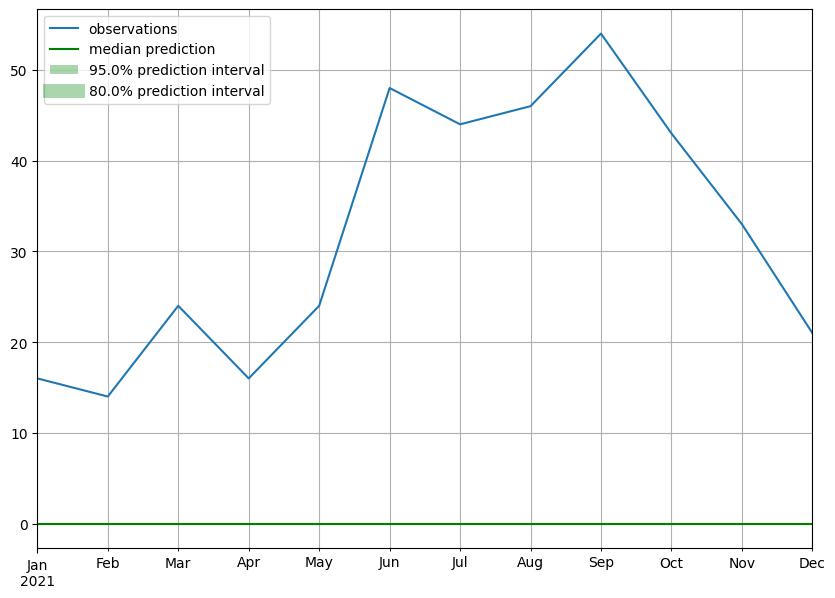

 17%|██████████▊                                                      | 1/6 [00:00<00:02,  2.31it/s]

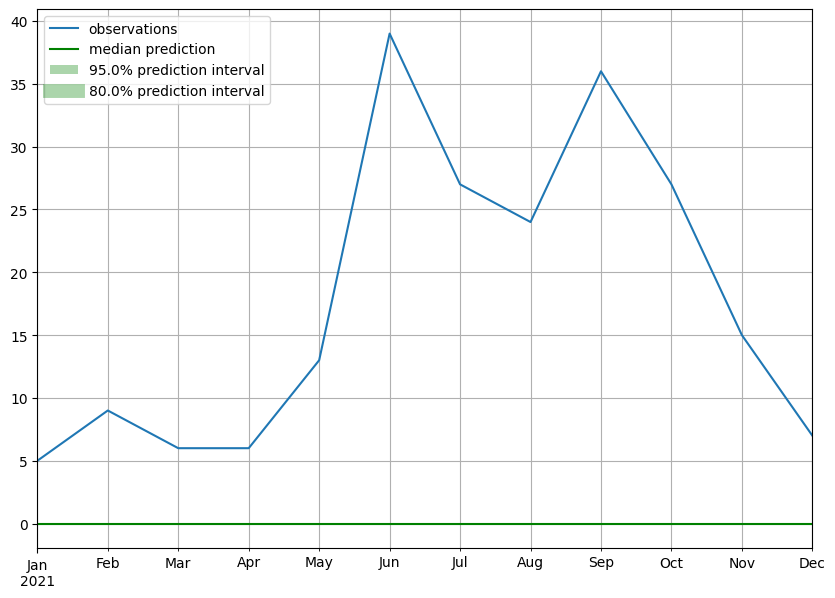

 33%|█████████████████████▋                                           | 2/6 [00:00<00:01,  2.18it/s]

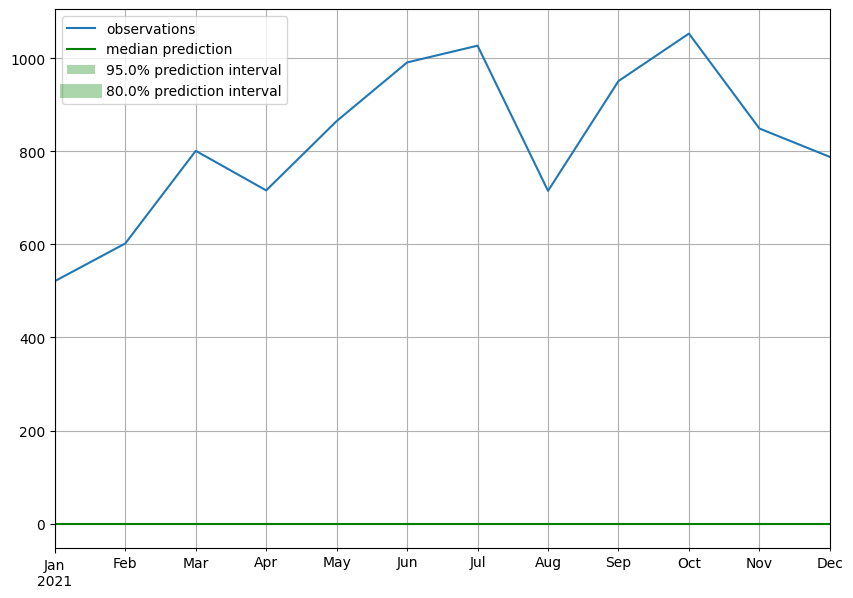

 50%|████████████████████████████████▌                                | 3/6 [00:01<00:01,  1.96it/s]

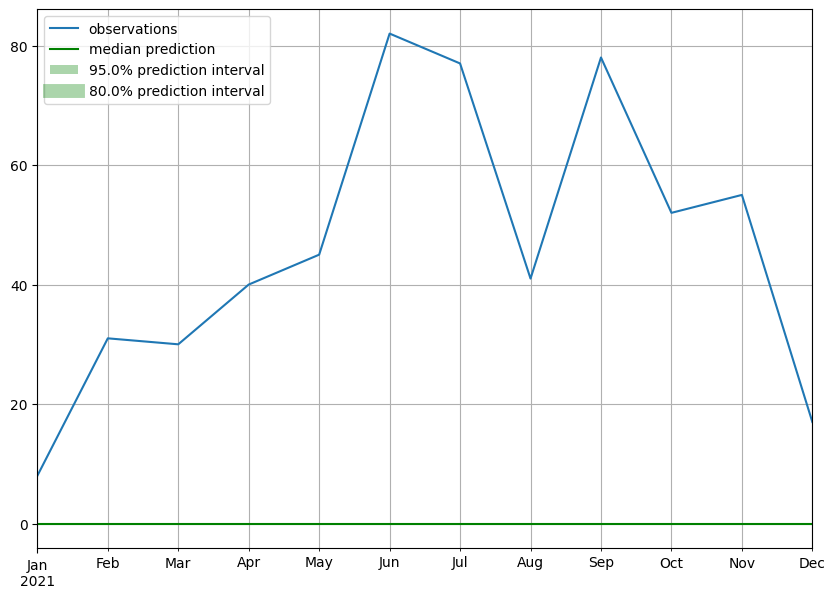

 67%|███████████████████████████████████████████▎                     | 4/6 [00:01<00:00,  2.18it/s]

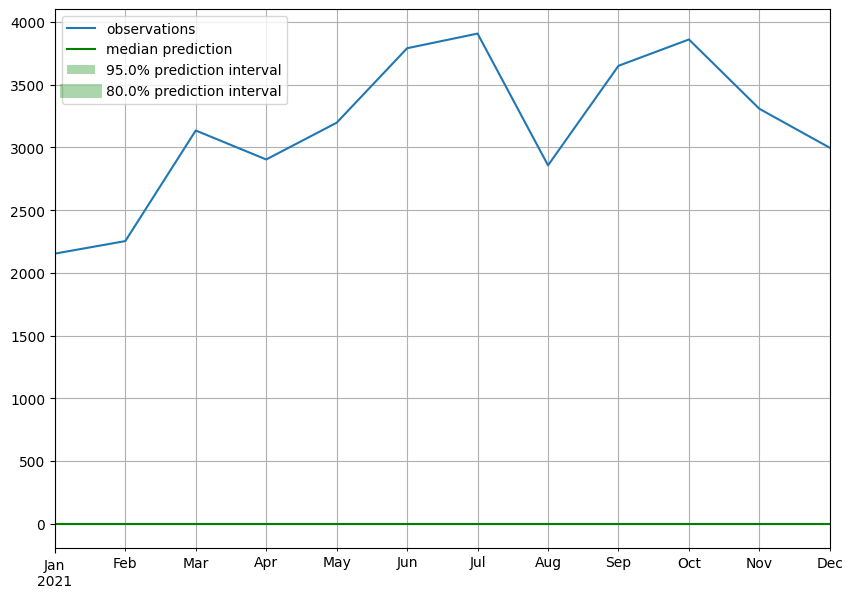

 83%|██████████████████████████████████████████████████████▏          | 5/6 [00:02<00:00,  2.02it/s]

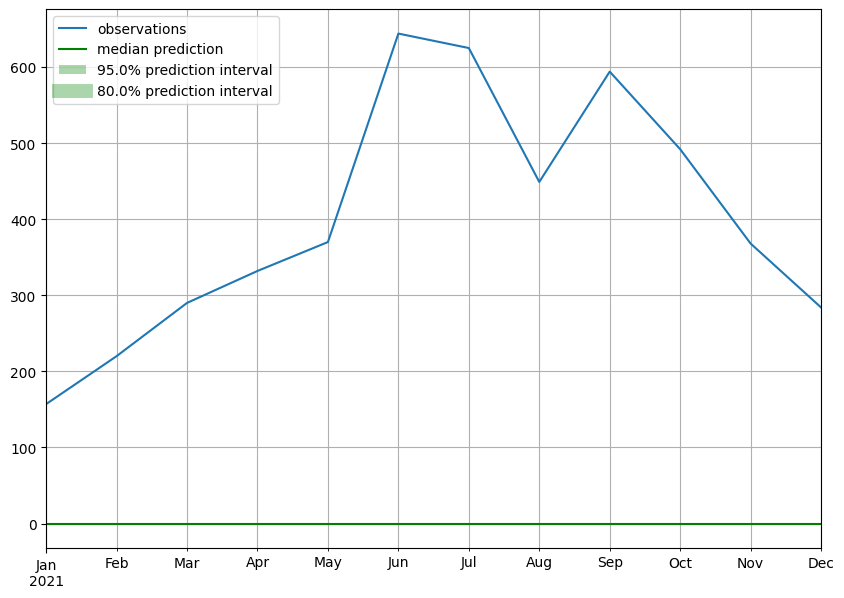

100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.05it/s]


In [402]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_length
    prediction_intervals = (80.0, 95.0)
    legend = ['observations', 'median prediction'] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 7))
    ts_entry[-plot_length:].plot(ax = ax)
    forecast_entry.plot(prediction_intervals = prediction_intervals, color='g')
    plt.grid(which='both')
    plt.legend(legend)
    plt.show()

for i in tqdm(range(6)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry)

In [403]:
evaluator = Evaluator(quantiles = [0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(df_test))
display(agg_metrics)
display(item_metrics)

Running evaluation: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 43.65it/s]
/usr/local/lib/python3.10/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.10/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in divide
  return numerator / seasonal_error
/usr/local/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


{'MSE': 1640765.5595238095,
 'abs_error': 59432.0,
 'abs_target_sum': 59432.0,
 'abs_target_mean': 707.5238095238094,
 'seasonal_error': nan,
 'MASE': nan,
 'MAPE': 1.0,
 'sMAPE': 2.0,
 'MSIS': nan,
 'QuantileLoss[0.1]': 11886.4,
 'Coverage[0.1]': 0.0,
 'QuantileLoss[0.5]': 59432.0,
 'Coverage[0.5]': 0.0,
 'QuantileLoss[0.9]': 106977.6,
 'Coverage[0.9]': 0.0,
 'RMSE': 1280.9237133896029,
 'NRMSE': 1.8104319545821554,
 'ND': 1.0,
 'wQuantileLoss[0.1]': 0.19999999999999998,
 'wQuantileLoss[0.5]': 1.0,
 'wQuantileLoss[0.9]': 1.8,
 'mean_absolute_QuantileLoss': 59432.0,
 'mean_wQuantileLoss': 1.0,
 'MAE_Coverage': 0.5,
 'OWA': nan}

item_id forecast_start           MSE  abs_error  abs_target_sum  \
0    None        2021-01  1.209250e+03      383.0           383.0   
1    None        2021-01  4.560000e+02      214.0           214.0   
2    None        2021-01  7.032764e+05     9879.0          9879.0   
3    None        2021-01  2.665500e+03      556.0           556.0   
4    None        2021-01  1.034685e+07    38015.0         38015.0   
5    None        2021-01  1.851846e+05     4825.0          4825.0   
6    None        2021-01  2.457132e+05     5560.0          5560.0   

   abs_target_mean  seasonal_error  MASE  MAPE  sMAPE   ND  MSIS  \
0        31.916667             NaN   NaN   1.0    2.0  1.0   NaN   
1        17.833333             NaN   NaN   1.0    2.0  1.0   NaN   
2       823.250000             NaN   NaN   1.0    2.0  1.0   NaN   
3        46.333333             NaN   NaN   1.0    2.0  1.0   NaN   
4      3167.916667             NaN   NaN   1.0    2.0  1.0   NaN   
5       402.083333             NaN   NaN   1.0    2.0  1.0   NaN   
6       463.333333             NaN   NaN   1.0    2.0  1.0   NaN   

   QuantileLoss[0.1]  Coverage[0.1]  QuantileLoss[0.5]  Coverage[0.5]  \
0               76.6            0.0              383.0            0.0   
1               42.8            0.0              214.0            0.0   
2             1975.8            0.0             9879.0            0.0   
3              111.2            0.0              556.0            0.0   
4             7603.0            0.0            38015.0            0.0   
5              965.0            0.0             4825.0            0.0   
6             1112.0            0.0             5560.0            0.0   

   QuantileLoss[0.9]  Coverage[0.9]  
0              689.4            0.0  
1              385.2            0.0  
2            17782.2            0.0  
3             1000.8            0.0  
4            68427.0            0.0  
5             8685.0            0.0  
6            10008.0            0.0

# Appendix

In [ ]:
# Going deeper into every accident-type
for acc in df_month['AUSPRAEGUNG'].unique():
    print(acc)
    sns.stripplot(data=df_month[df_month['AUSPRAEGUNG'] == acc], y='WERT', x='MONATSZAHL')
    plt.show()

In [ ]:
# Going deeper into every category
for cat in df_month['MONATSZAHL'].unique():
    print(cat)
    sns.stripplot(data=df_month[df_month['MONATSZAHL'] == cat], y='WERT', x='AUSPRAEGUNG')
    plt.show()

In [ ]:
# Line/Scatter plot total accidents in a year: Didn't give much insight
temp = df_year.copy()
temp['JAHR'] = temp['JAHR'].apply(lambda x: str(x)+'0101')
temp['JAHR'] = pd.to_datetime(temp['JAHR'])

sns.lineplot(data = temp, x = 'JAHR', y = 'WERT', hue='MONATSZAHL')
plt.show()
sns.scatterplot(data = temp, x = 'JAHR', y = 'WERT', hue='MONATSZAHL')
plt.show()

sns.lineplot(data = temp, x = 'JAHR', y = 'WERT', hue='AUSPRAEGUNG')
plt.show()
sns.scatterplot(data = temp, x = 'JAHR', y = 'WERT', hue='AUSPRAEGUNG')
plt.show()